# Template for multi-pitch detection TP

*(reference: Klapuri) but with pitch detection with spectral sum

*From G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [60]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil

Functions

In [61]:
def load_music(file):
    return wave.open(file, 'rb')


def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def f2idx(F, df):
    """
    Convert frequency to corresponding index in "frequencies" array
    """
    return ceil(F/df)

## 0 - Reading and playing .wav file

Choose the name of music for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [62]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'sons_multipitch')
filename = 'A4_piano.wav'
music = os.path.join(data_path, filename) 

### **Using wave**

In [63]:
wavefile = load_music(music)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=31994, comptype='NONE', compname='not compressed')


In [64]:
play = True
if play :
    play_music(music) 

In [65]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [66]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

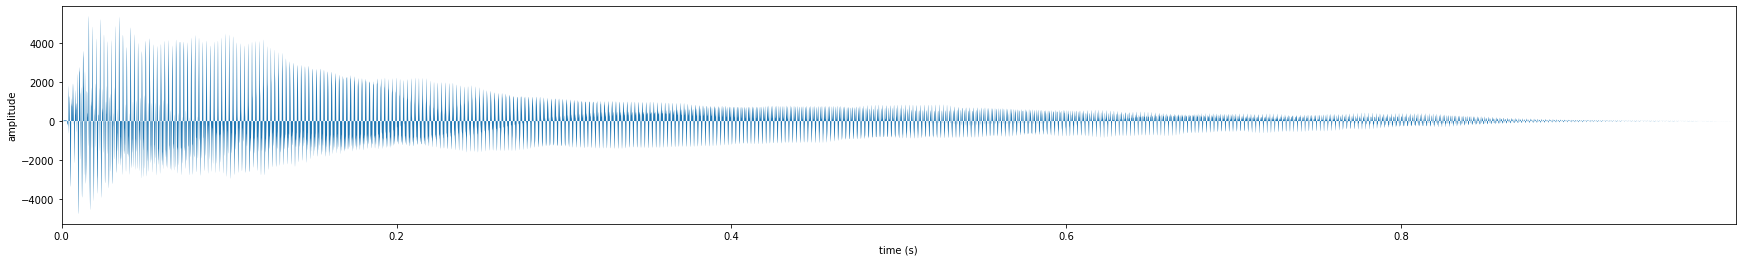

In [67]:
plot_sound(x, times)

## I - Window and Fast Fourier Transform


**1. Window size :** A Hamming window is used, its length covering $700$ ms of the entire signal 

**2. Offset :** The offset is chosen to be about $100$ ms, 

**3. Spectral precision after the FFT :** The frequency precision is given by $dF_{\text{min}}=\frac{F_{s}}{Nfft}$, where $Nfft$ is the size of the FFT window. 


In [68]:
N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
dF_min=Fs/N   # Minimal frequency resolution
print('The minimal frequency resolution is of {:.2f} Hz'.format(dF_min))

The minimal frequency resolution is of 1.43 Hz


In [69]:
w=np.hamming(N)  # Window
width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
eps=float(1e-20)   #precision

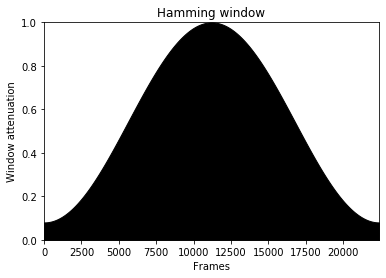

In [70]:
plt.fill_between(np.arange(len(w)), w, color='k')
plt.title('Hamming window')
plt.xlabel('Frames')
plt.ylabel('Window attenuation')
plt.xlim(0, len(w))
plt.ylim(0, 1)
plt.show()

### Discarding the attack of the sound

In [71]:
offset=ceil(0.1*Fs)
xw=x[offset:offset+N]*w    # xw is the analysed signal frame
n_xw = xw.size

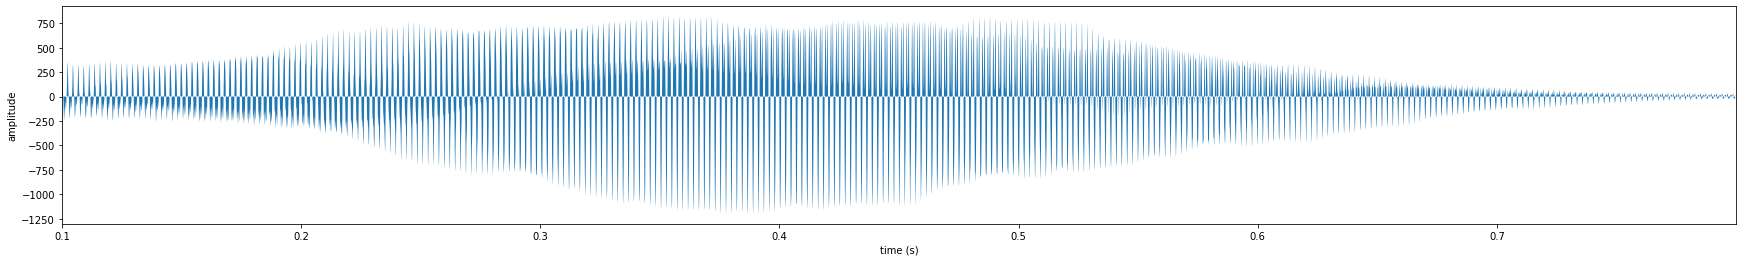

In [72]:
plot_sound(xw, times[offset:offset+N])

This is the temporal visualization of the sound we will be working on.

### Processing for efficient FFT (*by truncating to powers of 2*)

In [73]:
#Minimal number of data points to satisfy the minimal frequency resolution
Nfft_min=Fs/dF_min

#compute the smallest power of two that satisfies the minimal frequency resolution for FFT
p, Nfft = nextpow2(Nfft_min)
x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
x_fft /= np.max(np.abs(x_fft))+eps # Normalization

df=Fs/Nfft # frequency virtual resolution of FFT 
print('Frequency virtual resolution of FFT {:.2} Hz'.format(df))

Frequency virtual resolution of FFT 0.98 Hz


In [74]:
frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)

Plot FFT spectrum

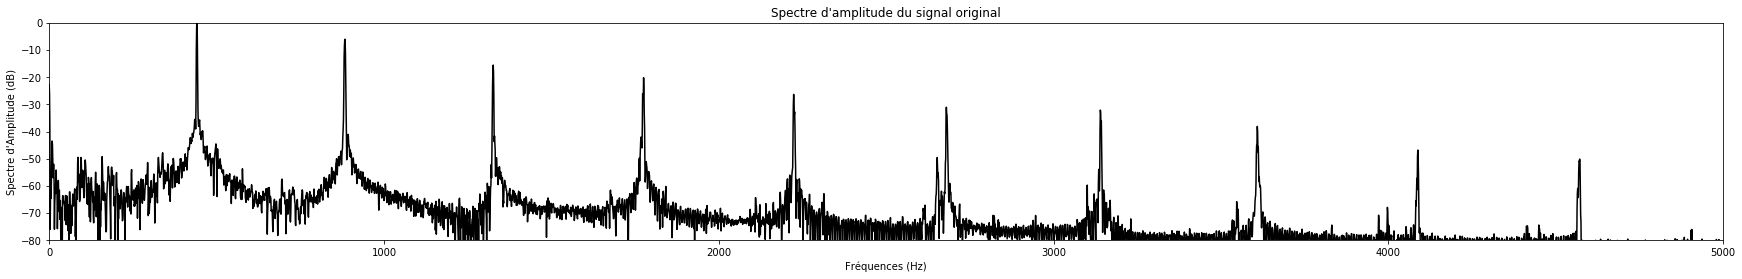

<Figure size 432x288 with 0 Axes>

In [86]:
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
plt.xlim(0, 5000)
plt.ylim(-80, 0)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title('Spectre d\'amplitude du signal original')
plt.show()
plt.clf()

For **A4_piano.wav**, we clearly see the harmonic around $\sim 440$ Hz and partials (multiples of the fundamental frequency peak).

In [87]:
freq = frequencies[:int(Nfft/2)] # array containing the x-axis of the plot above. 
fourier = 20*np.log10(X_fft[:int(Nfft/2)]) # array containing the y-axis of the plot above. 

The variable freq corresponds to the studied frequencies.

The variable fourier corresponds to the amplitude of the spectrum w.r.t the frequence in the array freq.

## II - Fundamental frequency estimation by spectral product/sum method

The different steps include :

#loop on the number of pitches
    - example criterion could use an energy ratio "while criterion > seuil_F0"
    
  #Detection of main F0
  
        -Compute spectral sum
        -locate maximum
        -store value of estimated F0

  #Subtraction of main note (Main F0 with its harmonics)
        
        -localisation of harmonics around theoretical values (with or without inharmonicy coefficient) 
        - beta: harmonicity coefficient ;  alpha: coefficient of tolerance
                
        - Harmonic suppression (wideness of an harmonic to be suppressed depends on the main lob of the TF of the analysis window); suppression of harmonics is done on abs(Xk) on forcing all values of a harmonic peak to the minimum value of the peak (e.g. the level of noise).
         
#end of loop

In [88]:
Fmin=100             # Minimal F0 frequency that can be detected
Fmax=900             # Maximal F0 frequency that can be detected
H=4                  # H = nombre de versions compressées
Rmax = ceil((Nfft-1)/(2*H)) # fréquence maximale
print(Rmax)
print(Nfft)

4096
32768


In [89]:
Nmin = f2idx(Fmin,df)-1
Nmax = f2idx(Fmax,df)
assert Nmax <= Rmax and Nmin >= 0

Functions sum and product

In [356]:
def preprocess_sound(filename = 'A4_piano.wav'):
    current_path = os.getcwd()
    data_path = os.path.join(current_path, 'sons_multipitch')
    music = os.path.join(data_path, filename) 
    wavefile = load_music(music)
    Fs = int(wavefile.getframerate())
    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack('{n}h'.format(n=num_samples), data)
    x = np.array(data)
    timestep = 1/float(Fs)
    times = np.arange(len(x))*timestep
    N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
    dF_min=Fs/N   # Minimal frequency resolution
    w=np.hamming(N)  # Window
    width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
    eps=float(1e-20)   #precision
    offset=ceil(0.1*Fs)
    xw=x[offset:offset+N]*w    # xw is the analysed signal frame
    n_xw = xw.size
    #Minimal number of data points to satisfy the minimal frequency resolution
    Nfft_min=Fs/dF_min
    #compute the smallest power of two that satisfies the minimal frequency resolution for FFT
    p, Nfft = nextpow2(Nfft_min)
    x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
    x_fft /= np.max(np.abs(x_fft))+eps # Normalization
    df=Fs/Nfft # frequency virtual resolution of FFT 
    frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
    X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)
    plt.figure(figsize=(30, 4))
    plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
    plt.xlim(0, 5000)
    plt.ylim(-80, 0)
    plt.xlabel('Fréquences (Hz)')
    plt.ylabel('Spectre d\'Amplitude (dB)')
    plt.title('Spectre d\'amplitude du signal original')
    plt.show()
    return frequencies, X_fft, Nfft

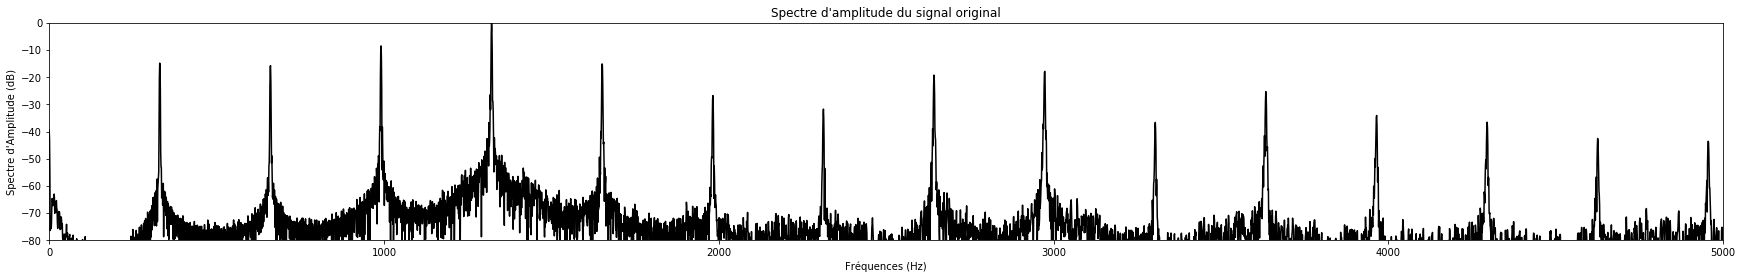

In [371]:
frequencies, X_fft, Nfft = preprocess_sound(filename = 'E4_oboe.wav')

freq = frequencies[:int(Nfft/2)] # array containing the x-axis of the plot above. 
fourier = 20*np.log10(X_fft[:int(Nfft/2)]) # array containing the y-axis of the plot above. 

The variable freq corresponds to the studied frequencies.

The variable fourier corresponds to the amplitude of the spectrum w.r.t the frequence in the array freq.

In [372]:
def concentrate_spectrum(x, h, R):
    '''
    Function that takes as input a vector x, i.e. the module of the fourier transformation,
    a integer h and a maximum length R, and outputs a vector of size R that encodes the module of the fourier
    transformation multiplied by h
    '''
    
    h = int(h)
    res = np.zeros(R)
    for i in range(R):
        for k in range(h):
            res[i] += x[h*i+k]
        res[i] = res[i]*1.0/h
    return res


def spectral_computation(fourier, H, R, product=False):
    '''Computation of the spectral sum if product==False, else computation of the spectral product'''
    
    modules = np.zeros((H, R))
    for h in range(1,H+1):
        modules[h-1] = concentrate_spectrum(fourier, h, R)
    if product:
        return np.prod(modules, axis=0)
    else:
        return np.sum(modules, axis=0)


def get_fundamental(freq, spec_computation, H, R, Fmin, Fmax, product=False):
    '''Returns the fundamental frequency and the index of this fundamental frequency'''
    
    plt.figure(figsize=(30, 4))
    plt.plot(freq[:R], spec_computation, color='k')
    plt.xlim(Fmin, Fmax)
    #plt.ylim(-80, 0)
    plt.xlabel('Frequencies (Hz)')
    plt.ylabel('Amplitude spectrum (dB)')
    plt.title('Spectral sum')
    plt.show()
    
    ind_min = len(freq[freq<Fmin])
    ind_max = len(freq[freq<Fmax])
    
    if product:
        return freq[np.argmin(spec_computation[ind_min:ind_max])+ind_min], np.argmin(spec_computation[ind_min:ind_max])+ind_min
    else:
        return freq[np.argmax(spec_computation[ind_min:ind_max])+ind_min], np.argmax(spec_computation[ind_min:ind_max])+ind_min



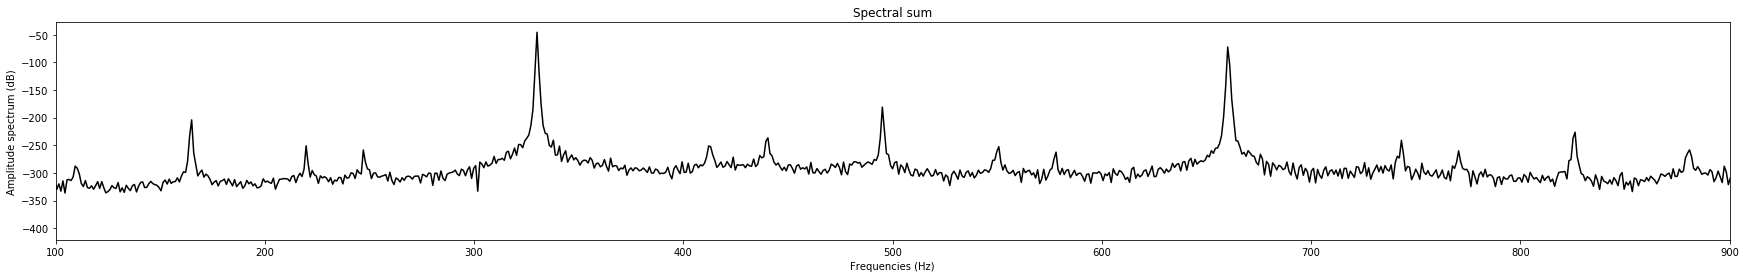

The fundamental frequency is 330.08 ± 1.43 Hz


In [373]:
Fmin=100    # Minimal F0 frequency that can be detected
Fmax=900    # Maximal F0 frequency that can be detected
H = 4
R = 4000    # Rmax = 4096
product = False
spec_computation = spectral_computation(fourier, H, R, product)
f_0, idx_f_0 = get_fundamental(freq, spec_computation, H, R, Fmin, Fmax, product)
print("The fundamental frequency is {:.5} ± {:.3} Hz".format(f_0, dF_min))

## II - Subtraction of the sound corresponding to the detected fundamental frequency

In [374]:
def delete_harmonic(freq, fourier, idx_note):
    
    gamma_plus = idx_note + 1
    gamma_moins = idx_note - 1
    while fourier[gamma_plus] > fourier[gamma_plus + 1] or fourier[gamma_moins] > fourier[gamma_moins - 1]:
        gamma_plus += 1
        gamma_moins -= 1

    if fourier[gamma_plus]<fourier[gamma_moins]:
        gamma = gamma_plus - idx_note
        freq_in_gamma = fourier[gamma_plus]
    else:
        gamma = idx_note - gamma_moins
        freq_in_gamma = fourier[gamma_moins]

    count = idx_note - gamma
    while count < idx_note + gamma:
        fourier[count] = freq_in_gamma
        count += 1
    
    plt.figure(figsize=(30, 4))
    plt.plot(freq, fourier, color='k')
    plt.xlim(0, 5000)
    plt.ylim(-80, 0)
    plt.xlabel('Fréquences (Hz)')
    plt.ylabel('Spectre d\'Amplitude (dB)')
    plt.title('Spectre d\'amplitude du signal original')
    plt.show()    
    
    return freq, fourier

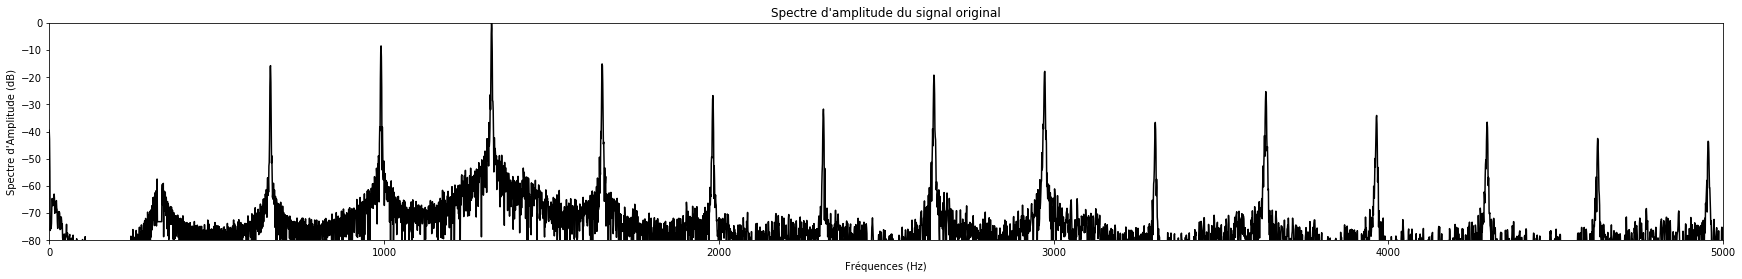

In [375]:
fr, fo = delete_harmonic(freq, fourier, idx_f_0)

In [346]:
def delete_note(freq, fourier, idx_note, freq_funda):
    freq_study = 2*freq_funda
    count = 2
    semitone_above = freq_funda*2**(1/12)
    alpha = semitone_above - freq_funda
    alpha_idx = len(freq[freq<alpha])
    while freq_study < 15000:
        #print(max(frequencies))
        current_idx = np.argmax(fourier[count*idx_note-alpha_idx:count*idx_note+alpha_idx]) + count*idx_note - alpha_idx
        print(freq_study)
        freq, fourier = delete_harmonic(freq, fourier, current_idx)
        count += 1
        freq_study = count*freq_funda
    
    return freq, fourier

882.8125


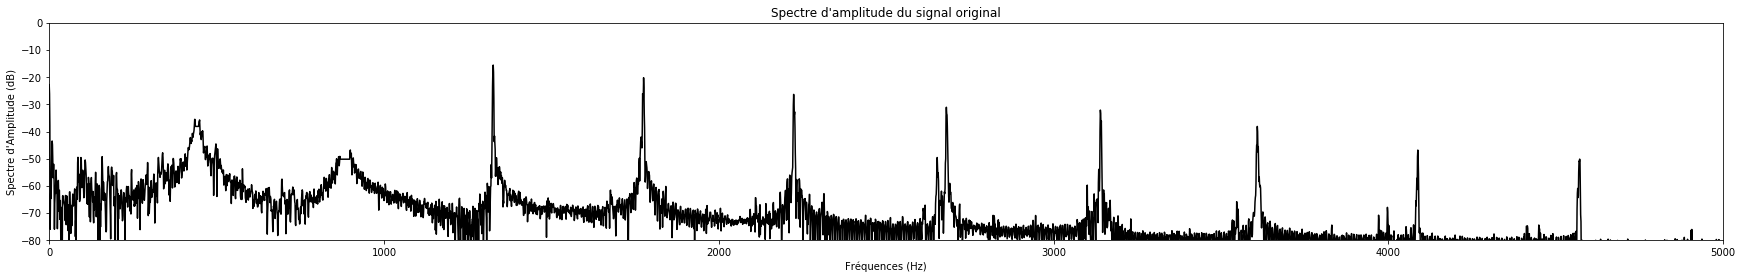

1324.21875


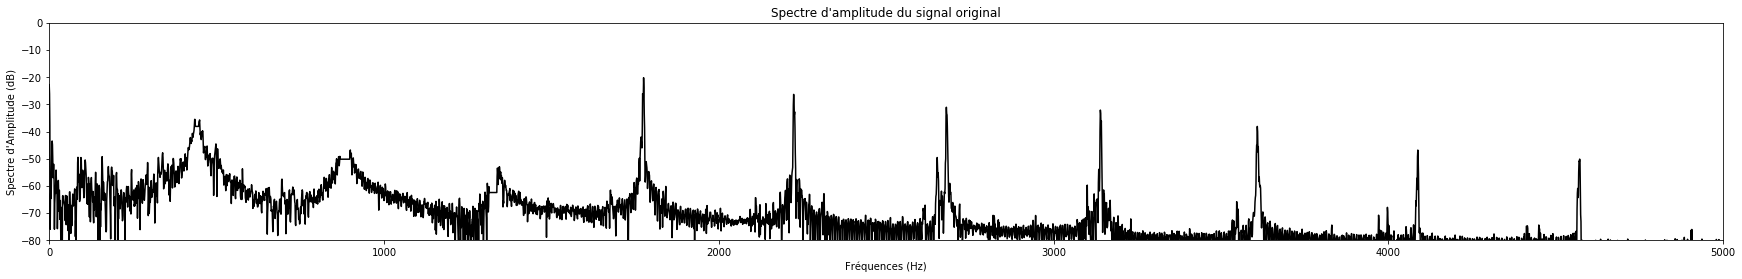

1765.625


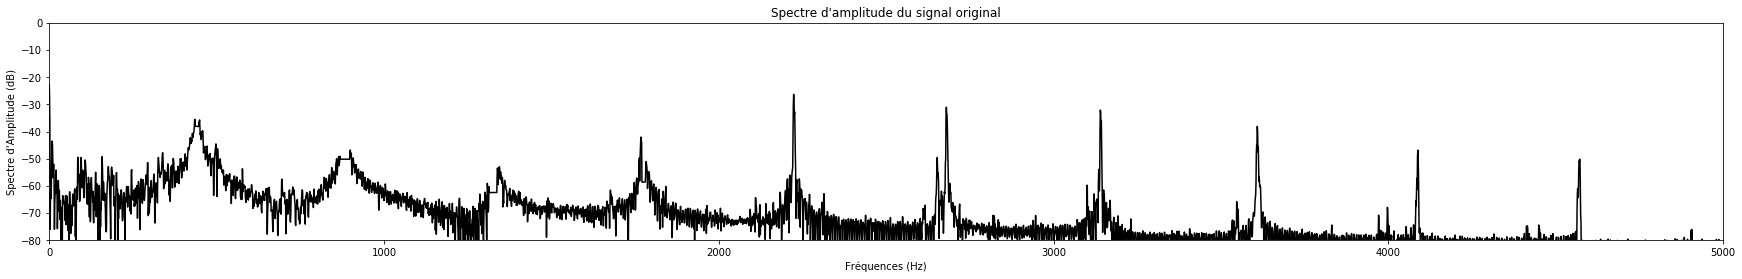

2207.03125


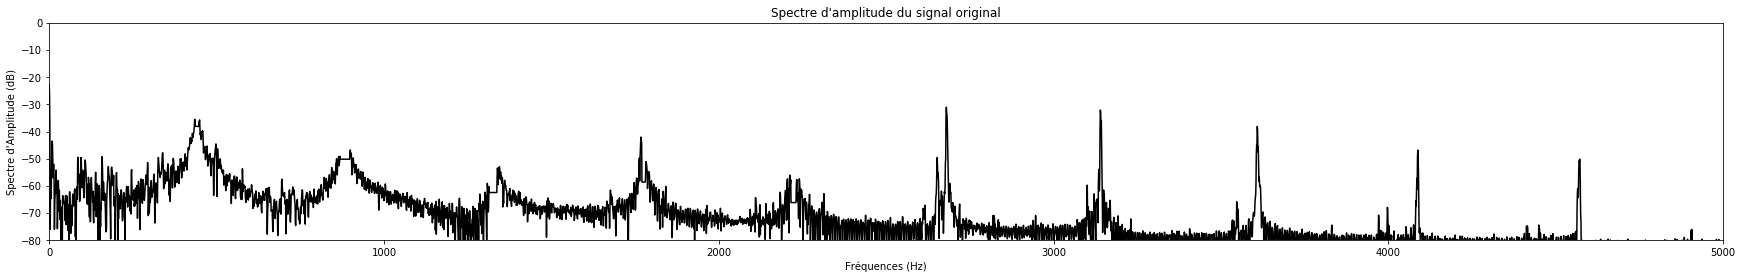

2648.4375


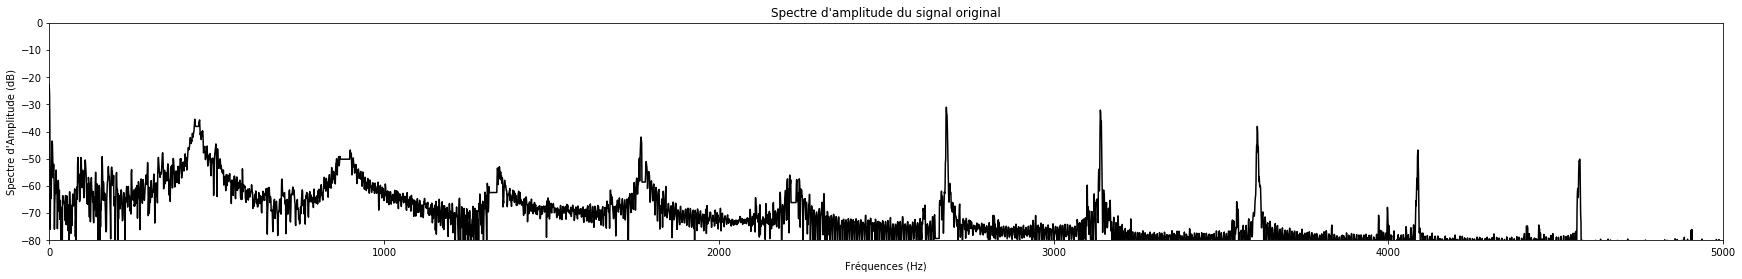

3089.84375


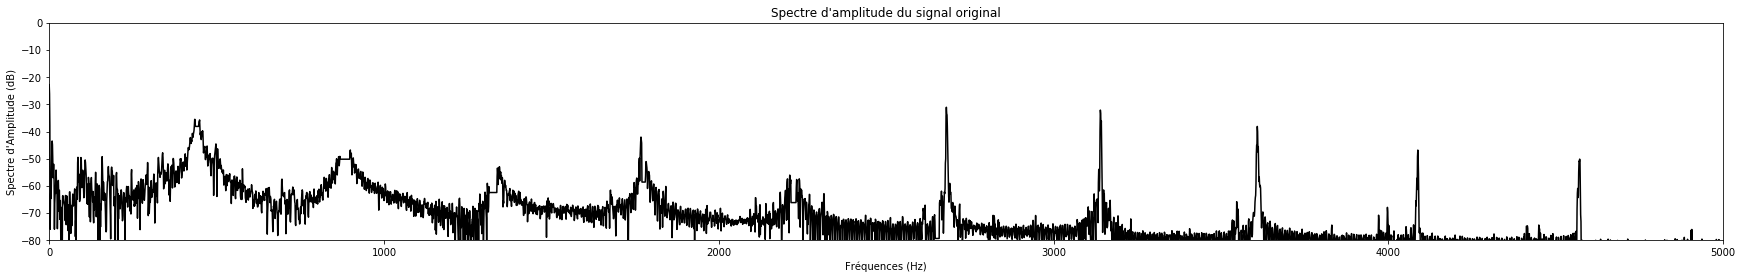

3531.25


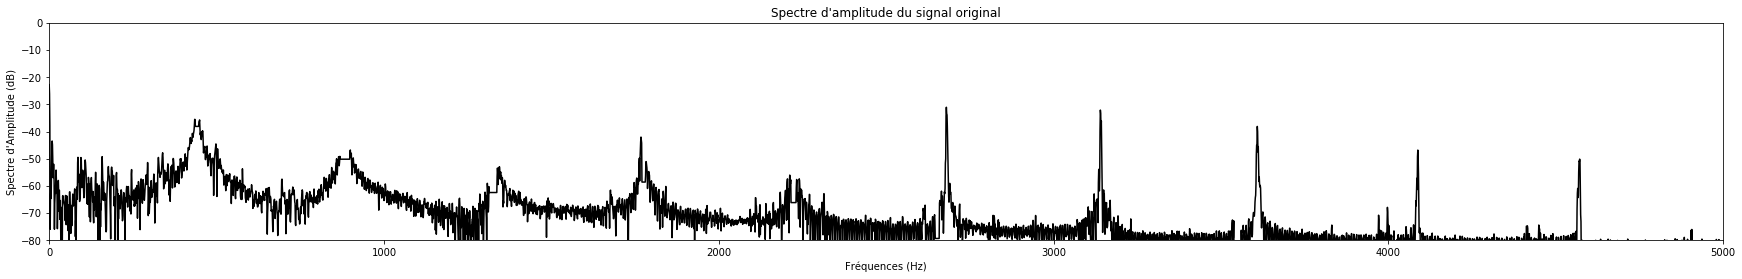

3972.65625


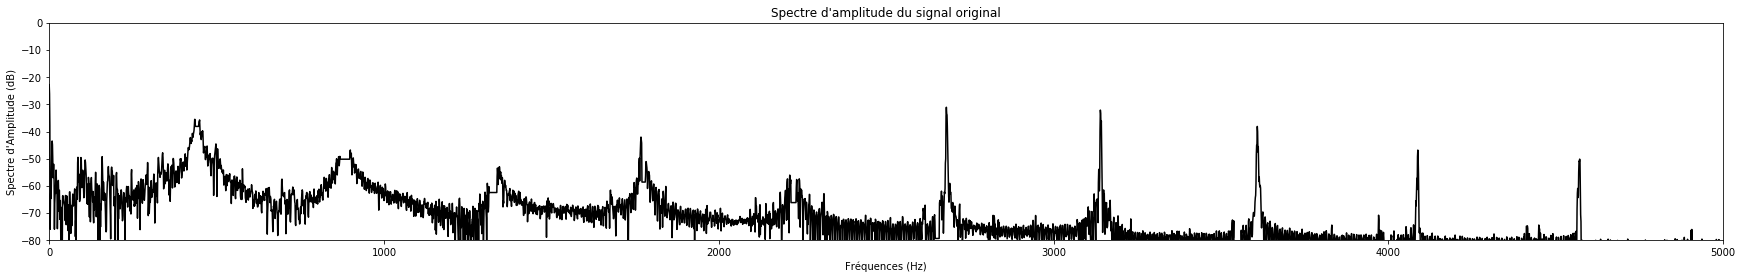

4414.0625


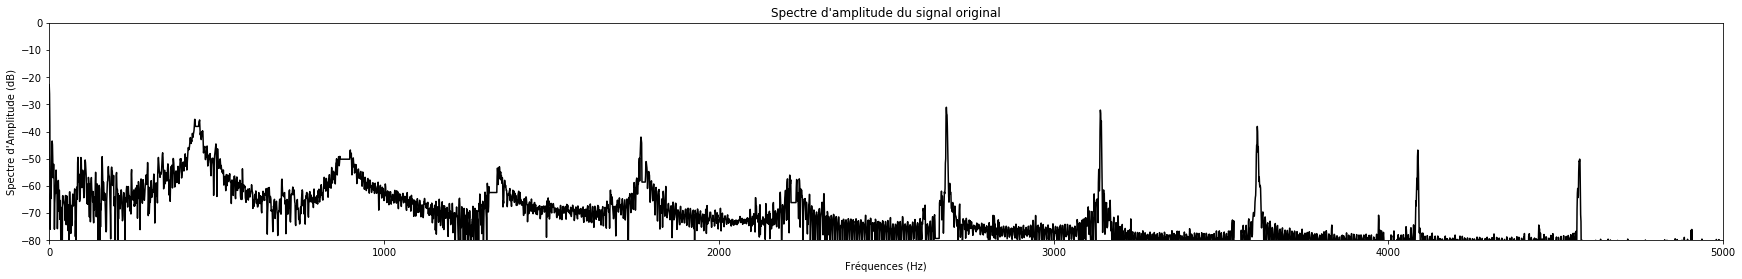

4855.46875


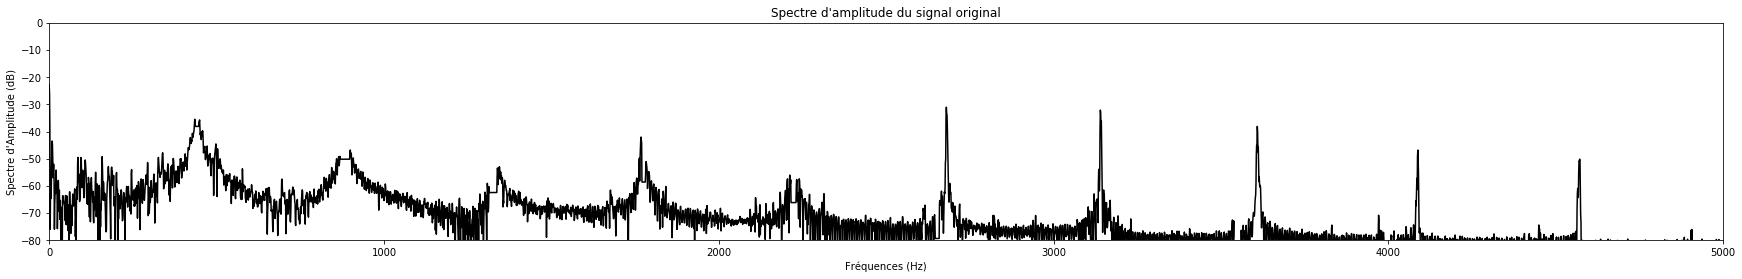

5296.875


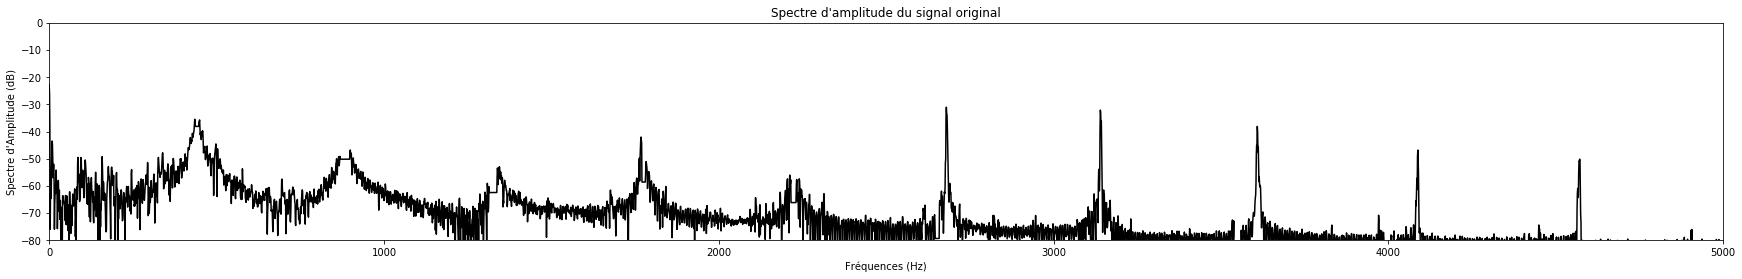

5738.28125


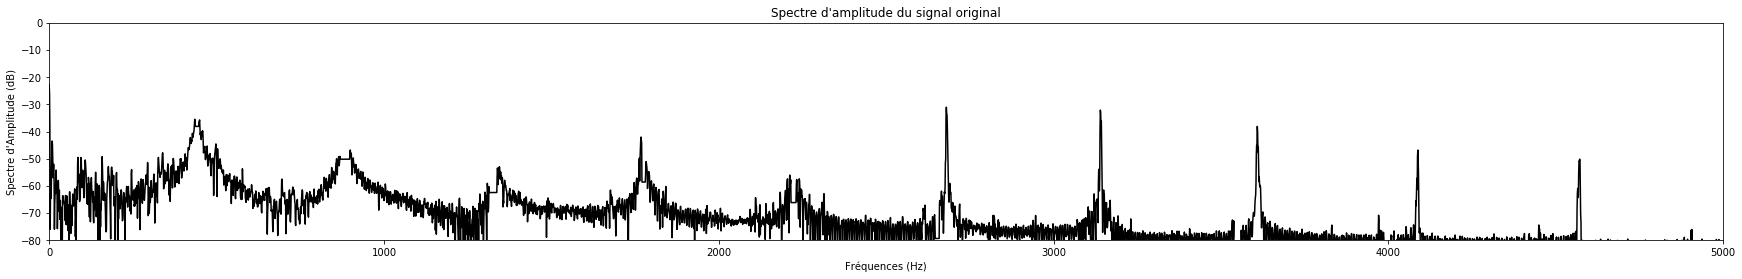

6179.6875


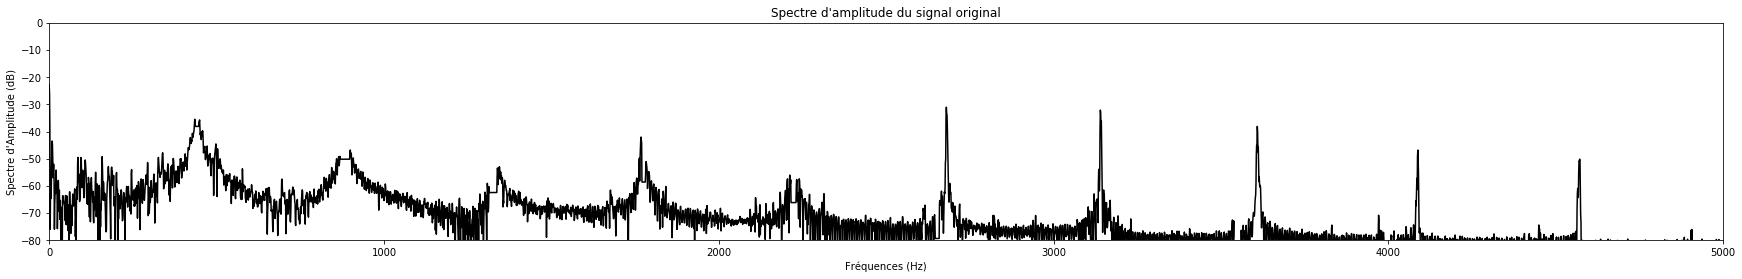

6621.09375


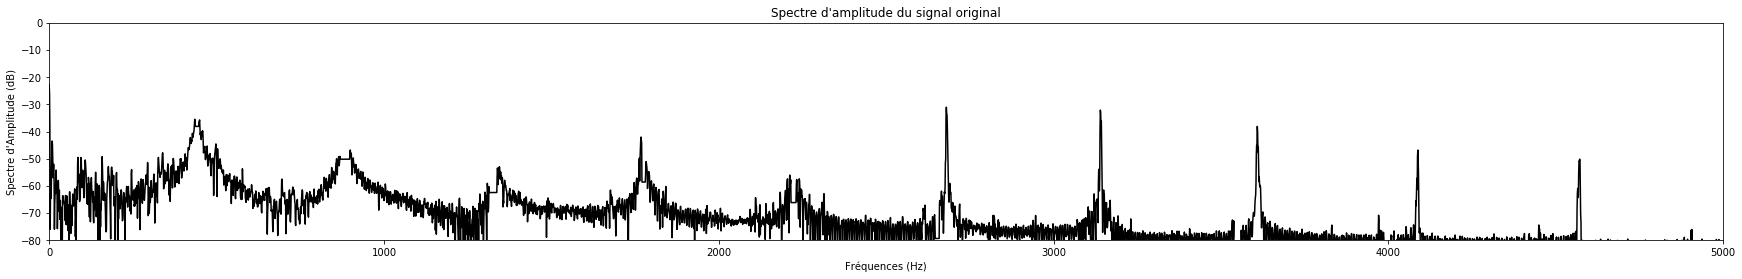

7062.5


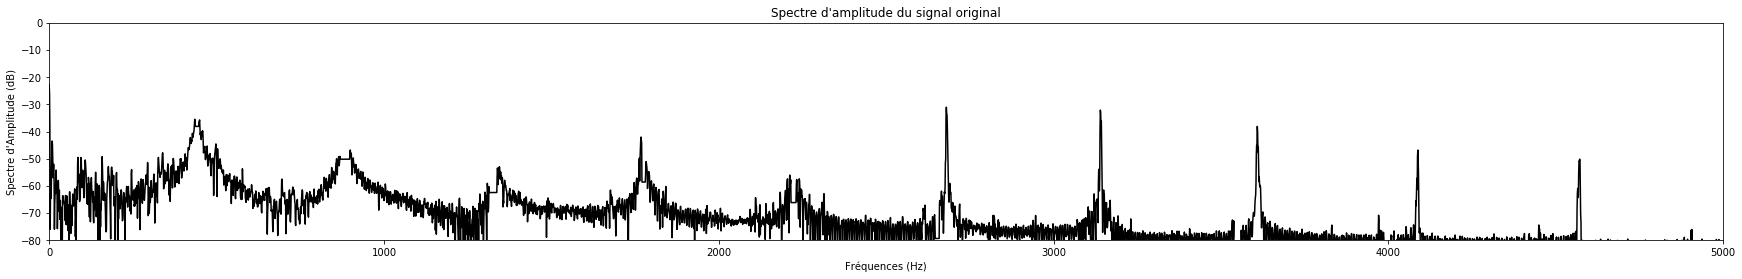

7503.90625


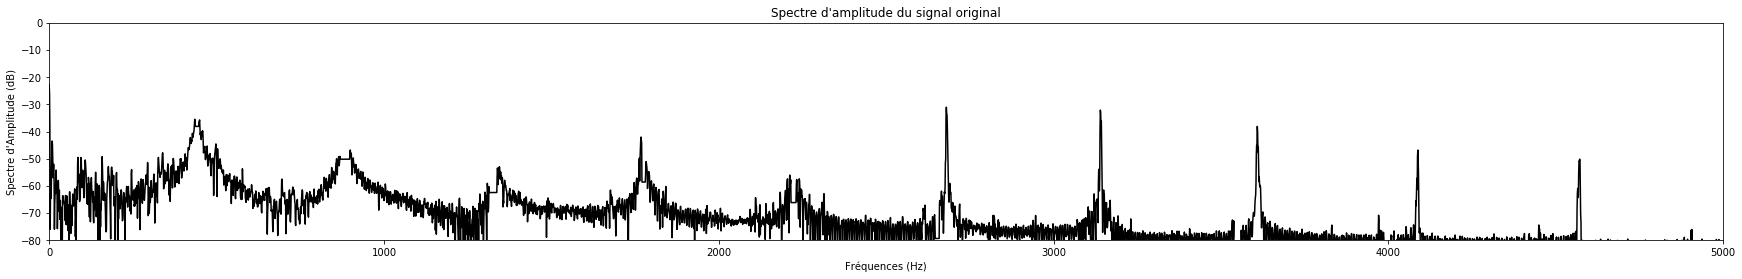

7945.3125


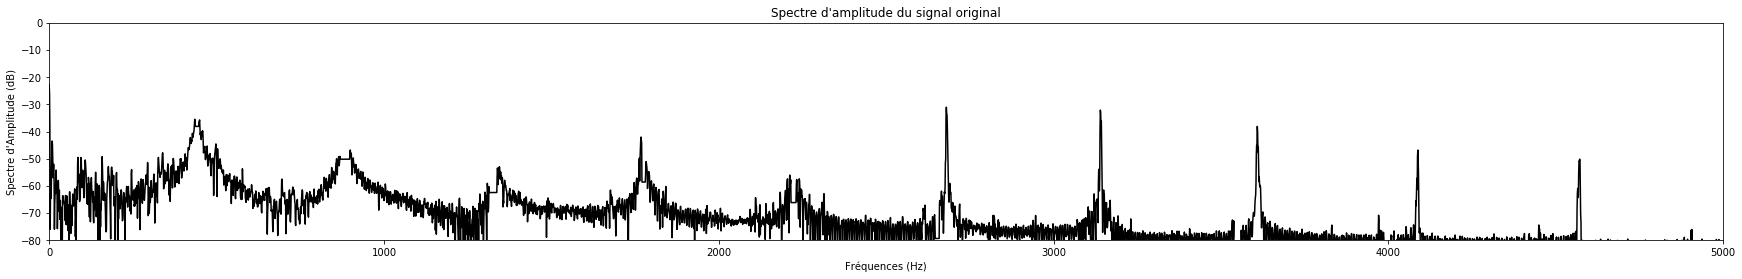

8386.71875


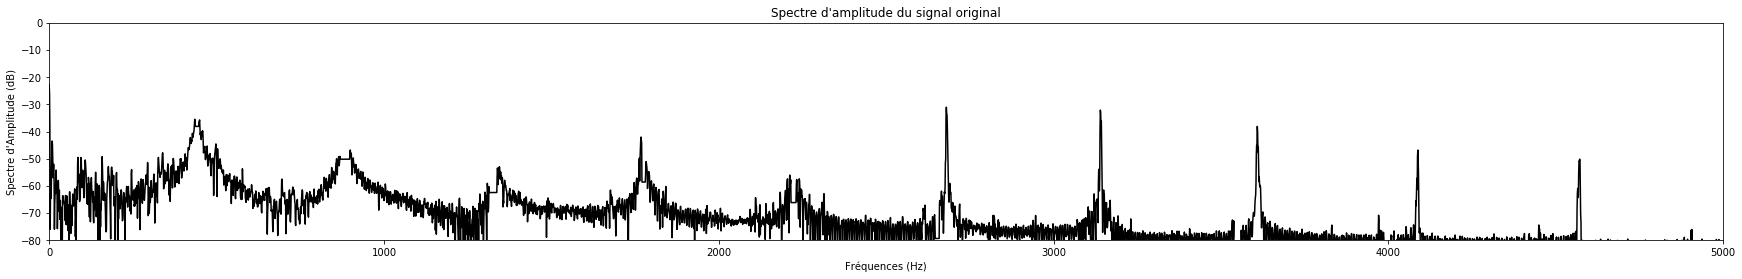

8828.125


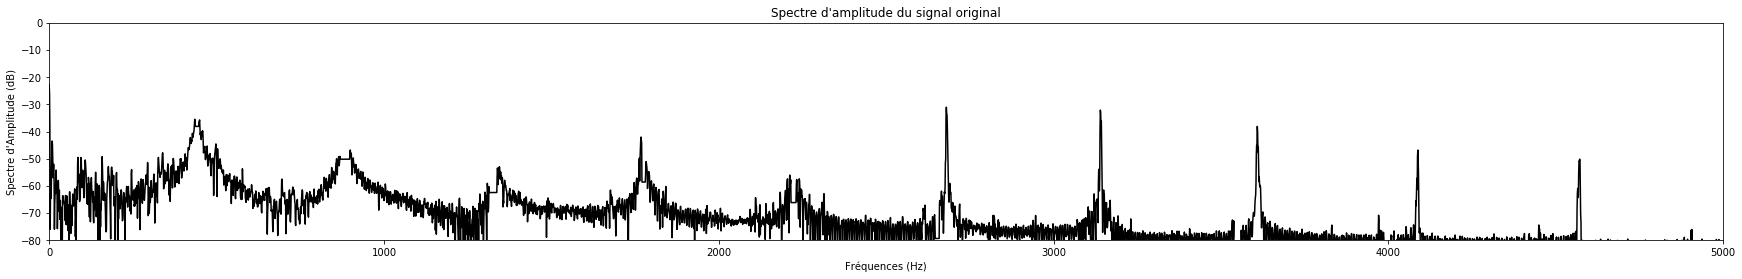

9269.53125


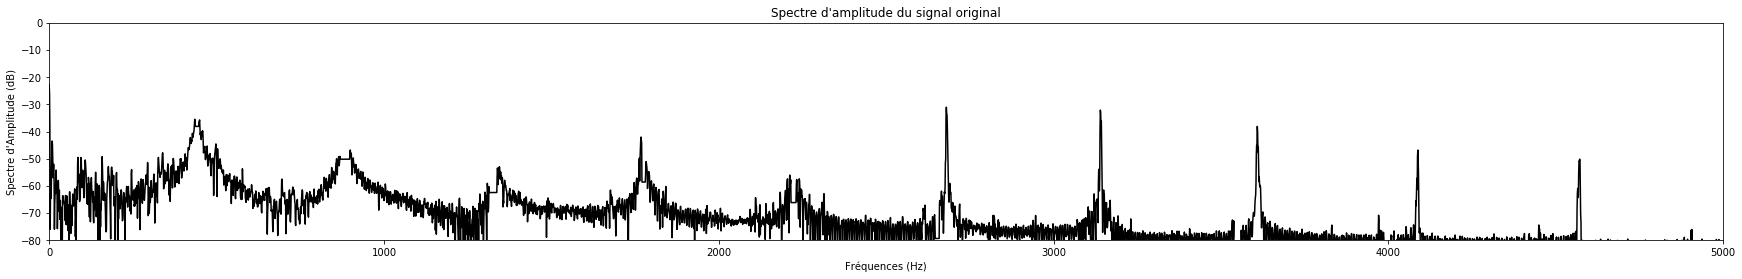

9710.9375


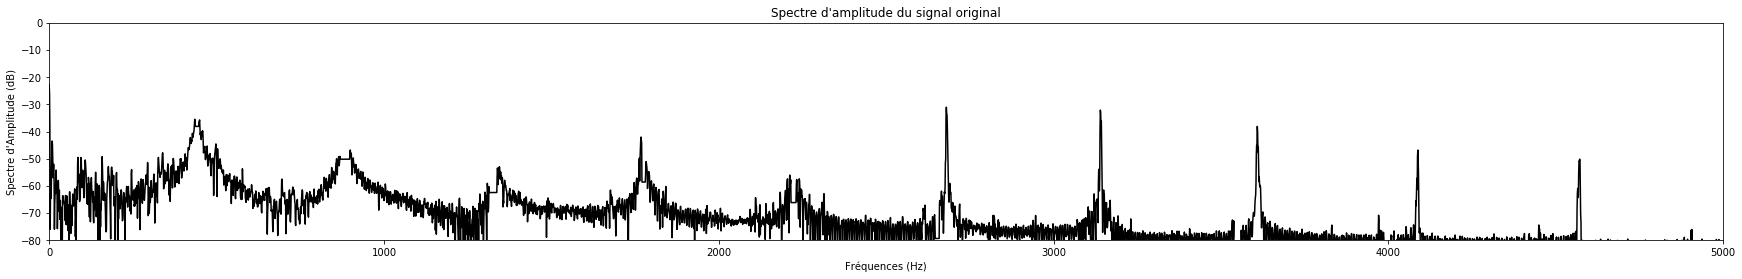

10152.34375


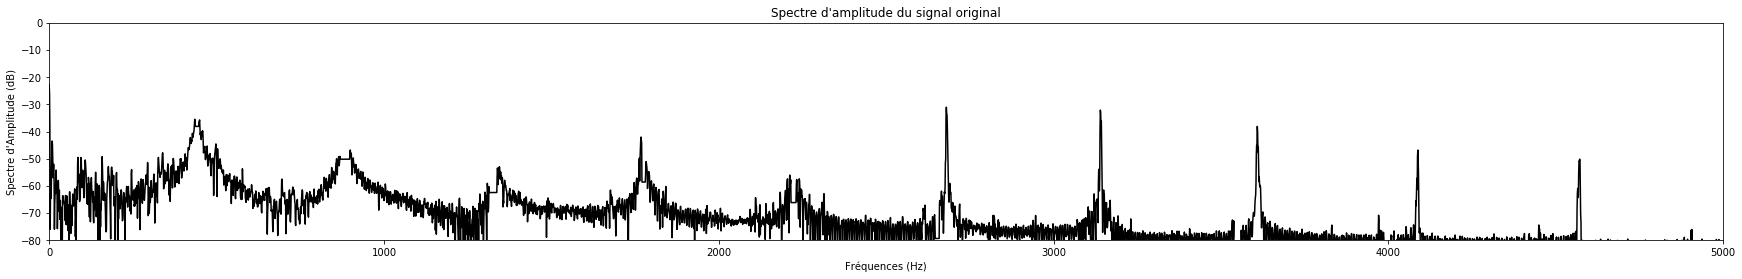

10593.75


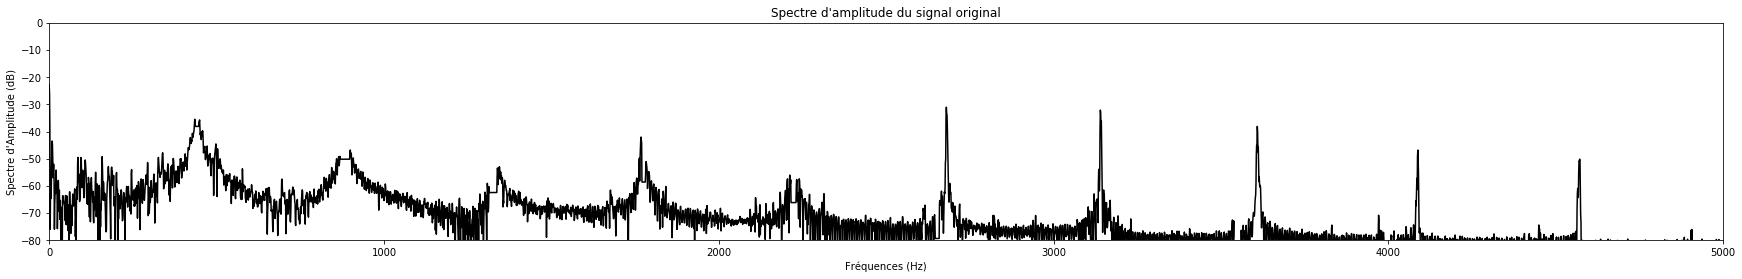

11035.15625


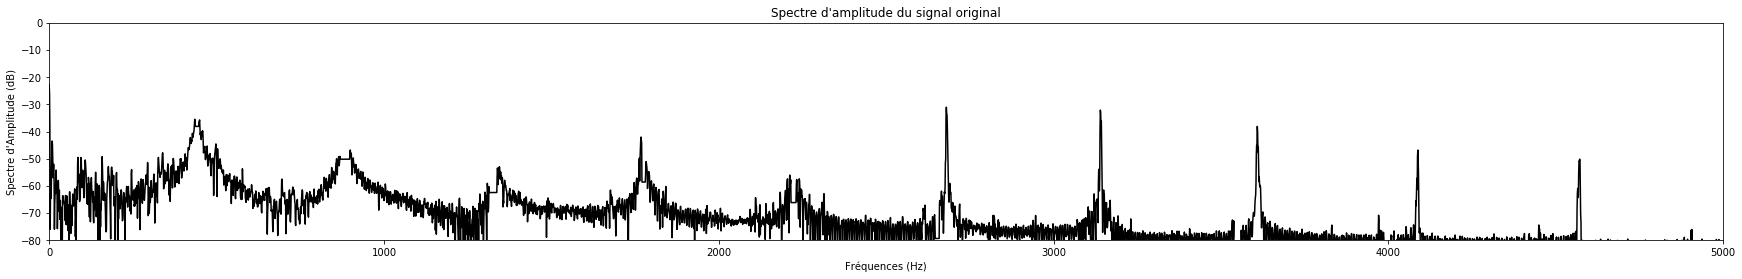

11476.5625


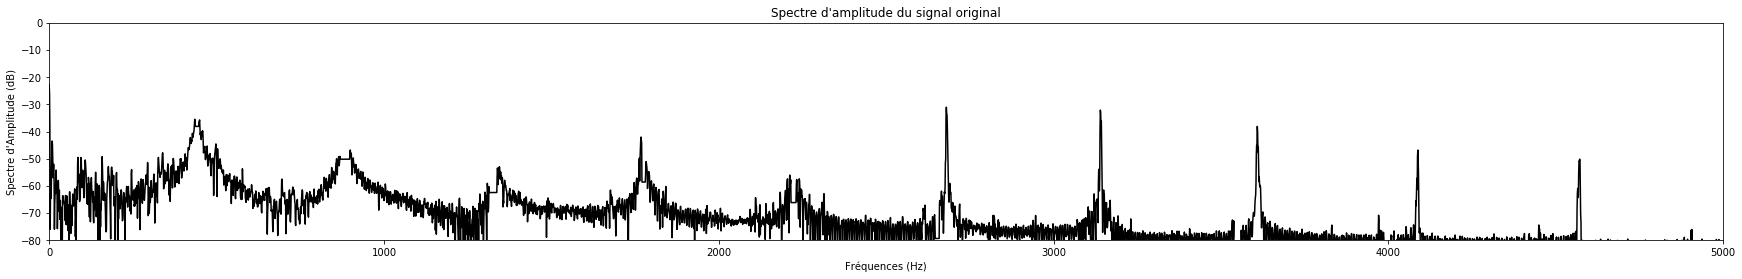

11917.96875


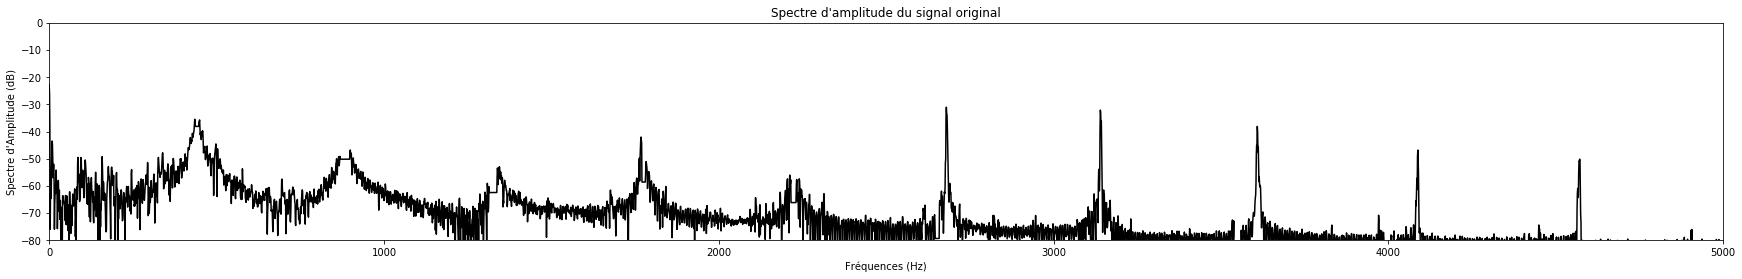

12359.375


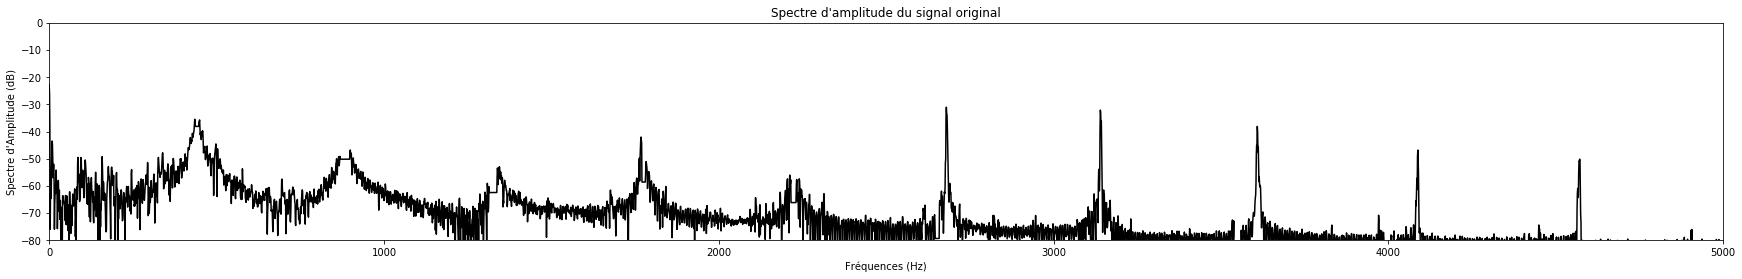

12800.78125


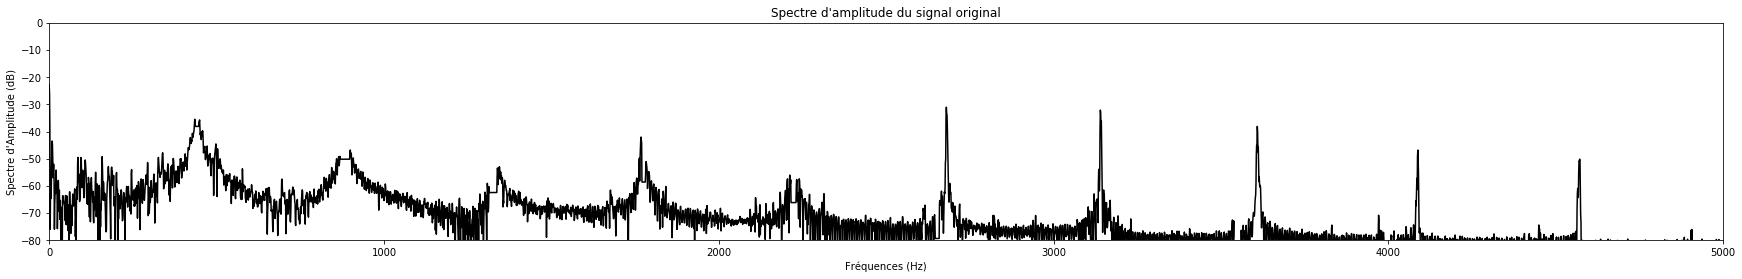

13242.1875


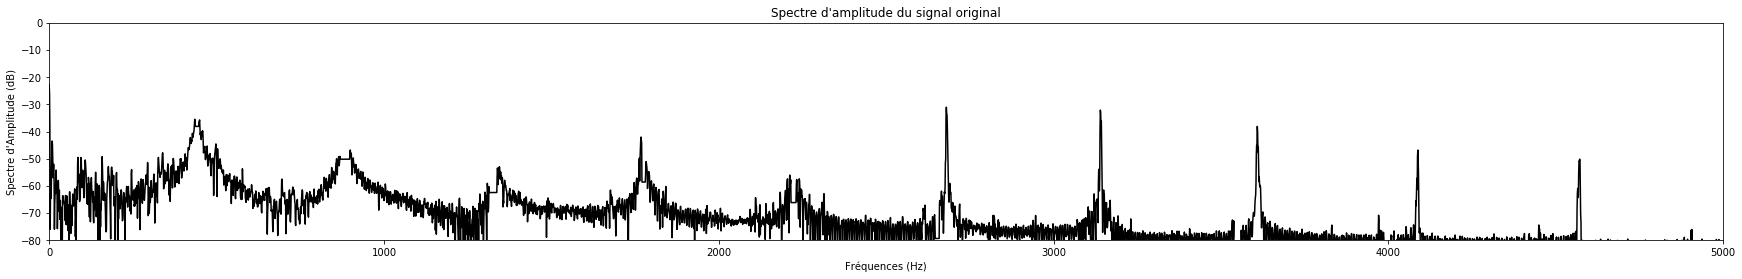

13683.59375


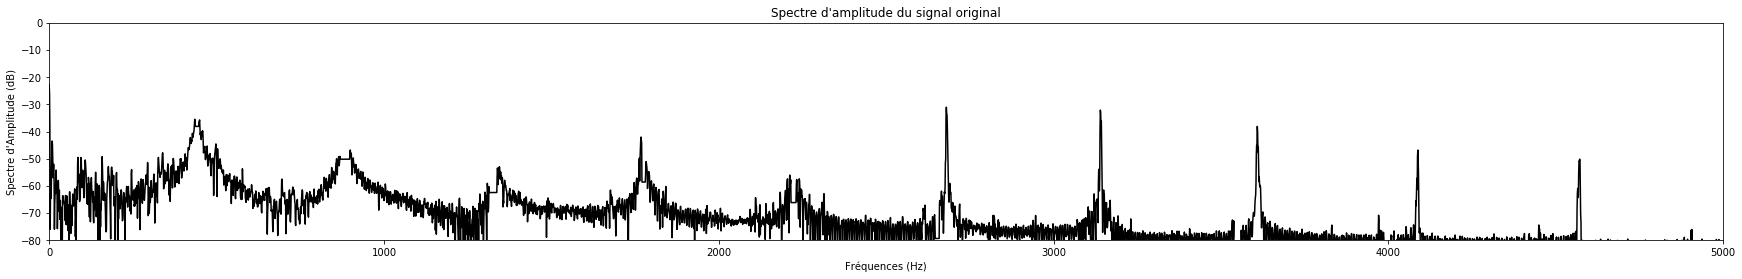

14125.0


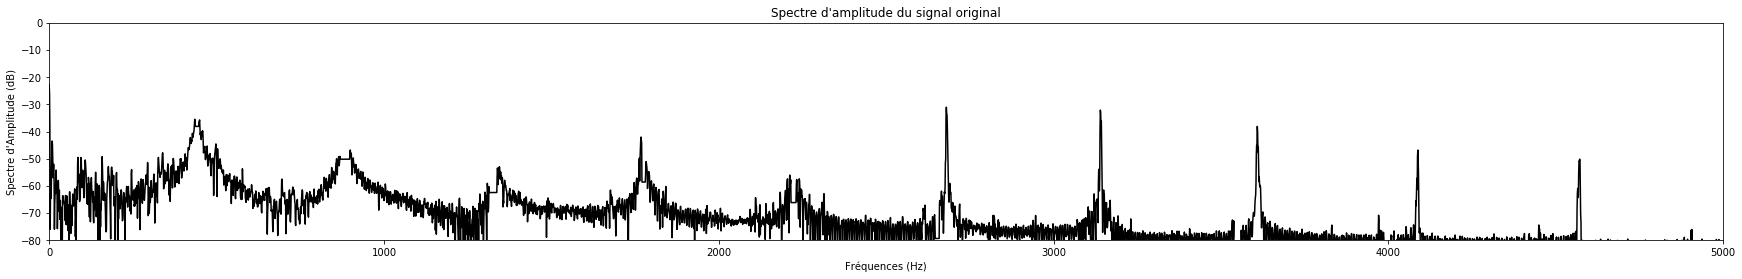

14566.40625


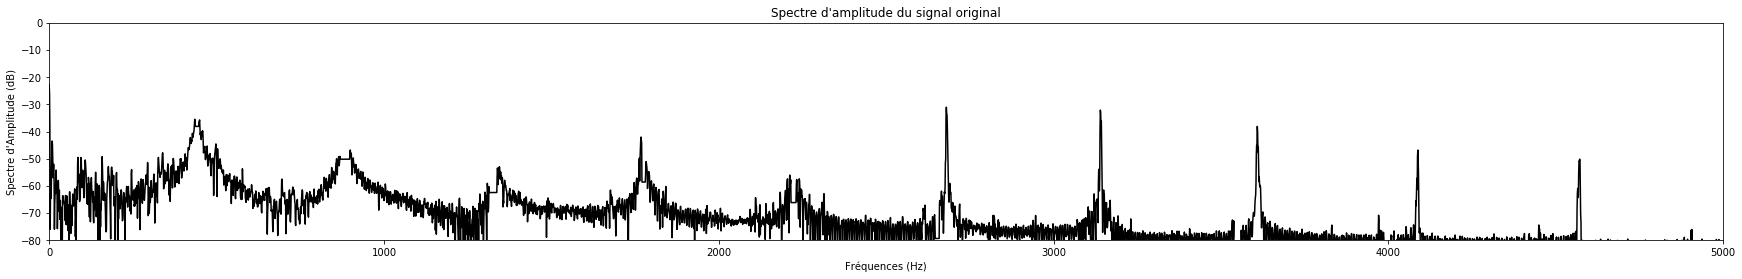

In [200]:
new_freq, new_fourier = delete_note(fr, fo, idx_f_0, f_0)

In [339]:
# automatic estimation of beta

from sklearn.linear_model import LinearRegression

def find_beta(freq, fourier, idx_note, freq_funda):
    freq_study = 2*freq_funda
    count = 2
    semitone_above = freq_funda*2**(1/12)
    alpha = semitone_above - freq_funda
    alpha_idx = len(freq[freq<alpha])
    current_idx_array = []
    
    while freq_study < 2000:
        #print(max(frequencies))
        current_idx = np.argmax(fourier[count*idx_note-alpha_idx:count*idx_note+alpha_idx]) + count*idx_note - alpha_idx
        print(freq_study)
        current_idx_array.append(current_idx)
        #freq, fourier = delete_harmonic(freq, fourier, current_idx)
        count += 1
        freq_study = count*freq_funda
    
    current_idx_array = np.array(current_idx_array)
    associated_freq = freq[current_idx_array]
    in_y = np.zeros_like(associated_freq)
    iny2 = np.zeros_like(associated_freq)
    inx2 = np.zeros_like(associated_freq)
    for i in range(len(in_y)):
        in_y[i] = ((associated_freq[i]/(i+2))**2 - freq_funda**2)/((i+2)*freq_funda)**2
        iny2[i] = (associated_freq[i]/((i+2)*freq_funda))**2
        inx2[i] = (i+2)**2
    beta = np.mean(in_y)
 #   print(iny2)
 #   print(inx2)
    
  #  regressor = LinearRegression()
   # regressor.fit(inx2, iny2)
    #print(regressor.coef_)
    
    return beta

beta = find_beta(fr, fo, idx_f_0, f_0)
print("beta = ", beta)

882.8125
1324.21875
1765.625
beta =  0.004365852978169061


In [376]:
def delete_note(freq, fourier, idx_note, freq_funda, inharmonicity=False):
    count = 2
    if inharmonicity:
        beta = find_beta(freq, fourier, idx_note, freq_funda)
       # beta = 0.0005
        freq_study = count*freq_funda*np.sqrt(1+beta*count**2)
    else:
        freq_study = count*freq_funda
        
    semitone_above = freq_funda*2**(1/12)
    alpha = semitone_above - freq_funda
    alpha_idx = 2*len(freq[freq<alpha])
    
    while freq_study < 15000:
        #print(max(frequencies))
        if inharmonicity:
            center = count*idx_note*int(np.sqrt(1+beta*count**2))
        else:
            center = count*idx_note
        current_idx = np.argmax(fourier[center-alpha_idx:center+alpha_idx]) + center - alpha_idx
        print(freq[count*idx_note-alpha_idx])
        print(freq[count*idx_note+alpha_idx])
        freq, fourier = delete_harmonic(freq, fourier, current_idx)
        count += 1
        #if inharmonicity:
        #    freq_study = count*freq_funda*np.sqrt(1+beta*count**2)
        #else:
        freq_study = count*freq_funda
    
    return freq, fourier

660.15625
990.234375
1320.3125
1650.390625
1980.46875
619.140625
701.171875


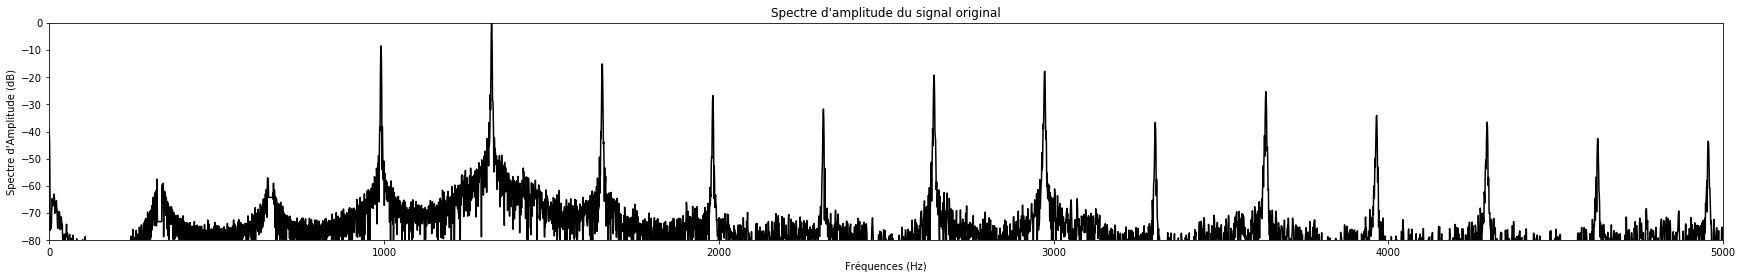

949.21875
1031.25


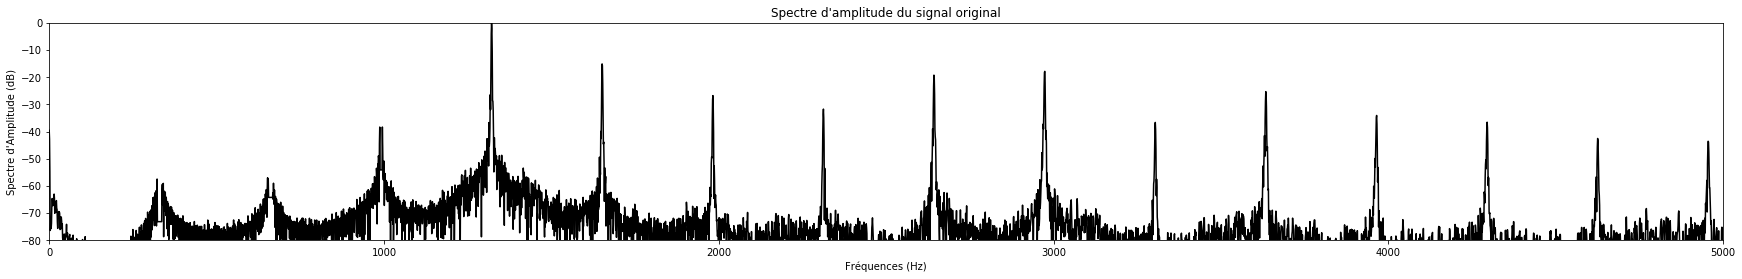

1279.296875
1361.328125


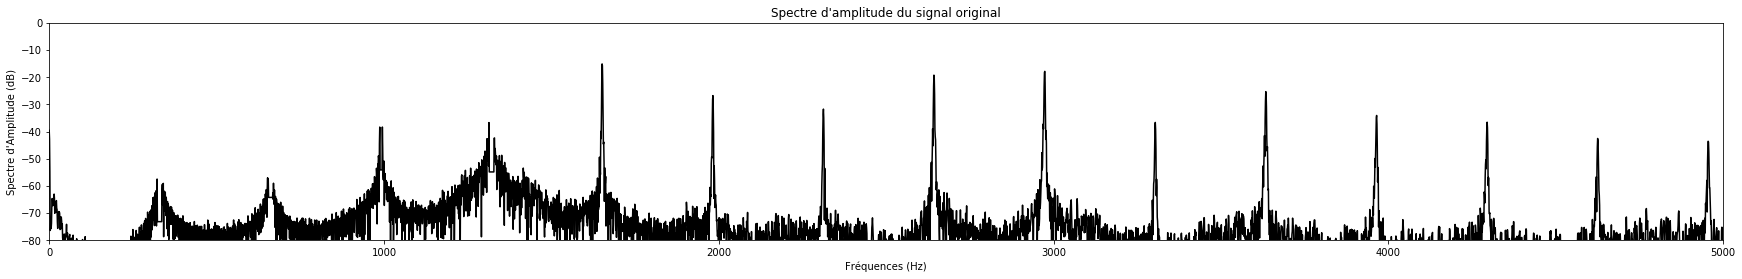

1609.375
1691.40625


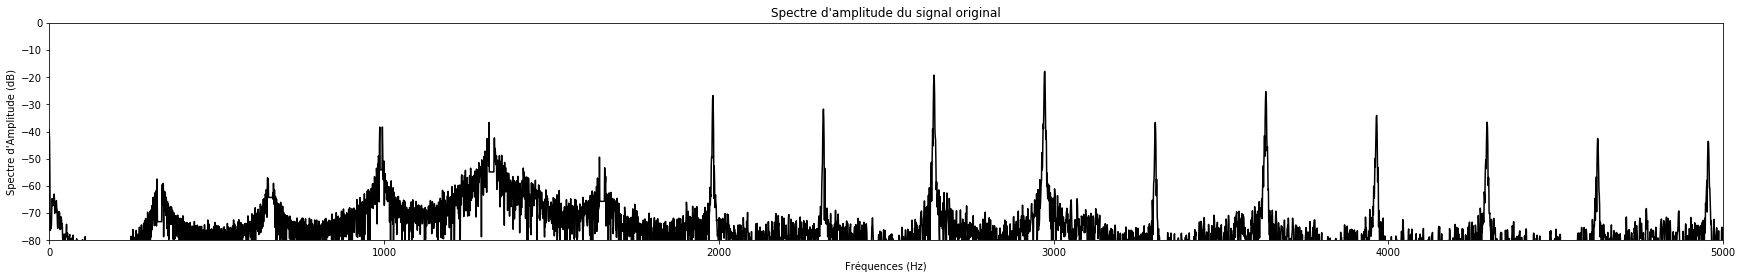

1939.453125
2021.484375


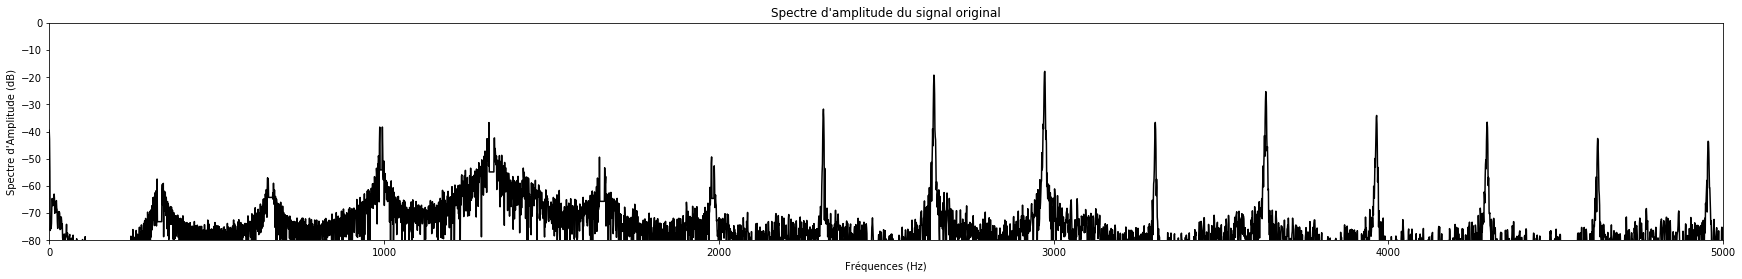

2269.53125
2351.5625


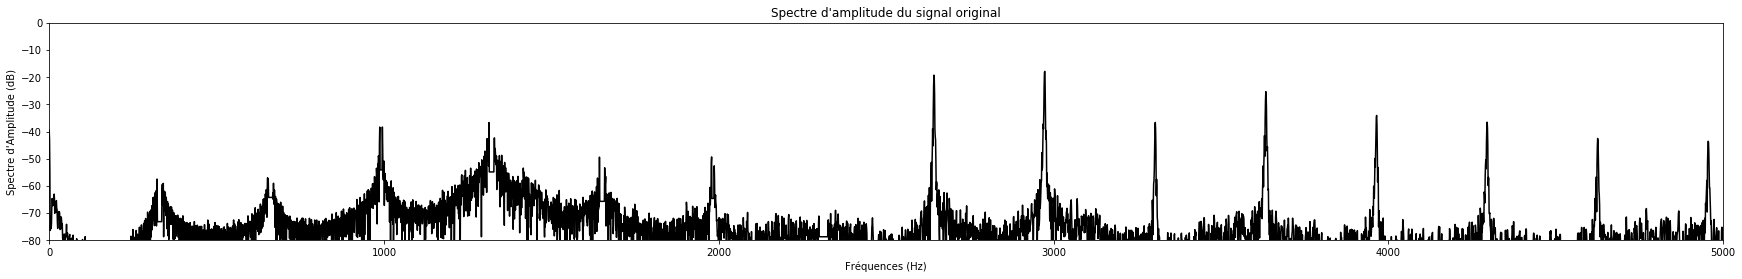

2599.609375
2681.640625


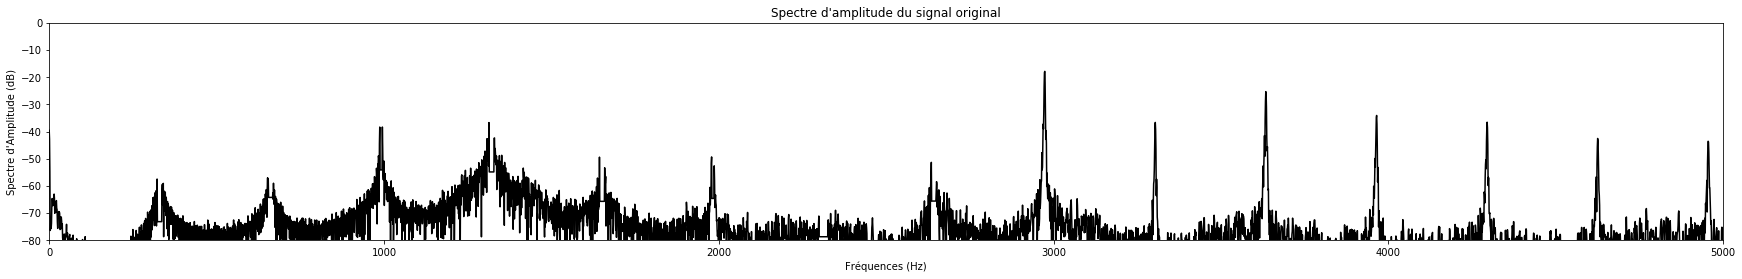

2929.6875
3011.71875


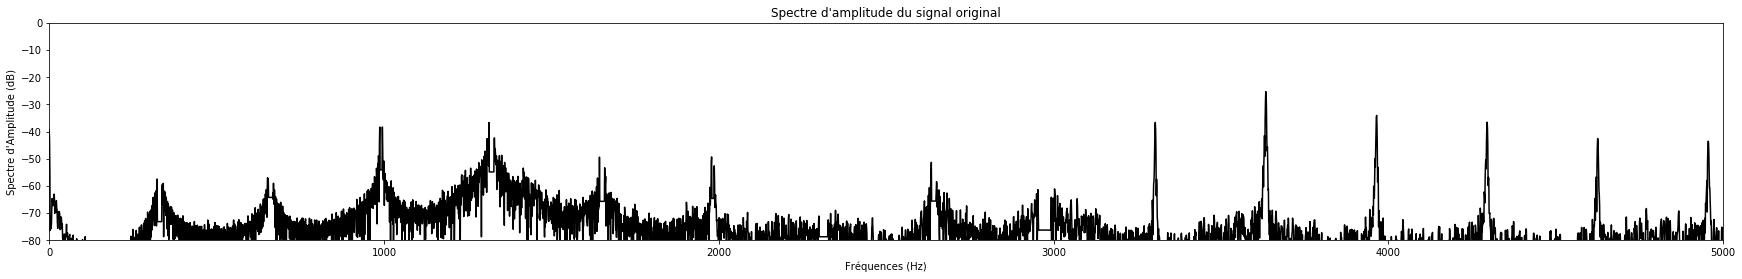

3259.765625
3341.796875


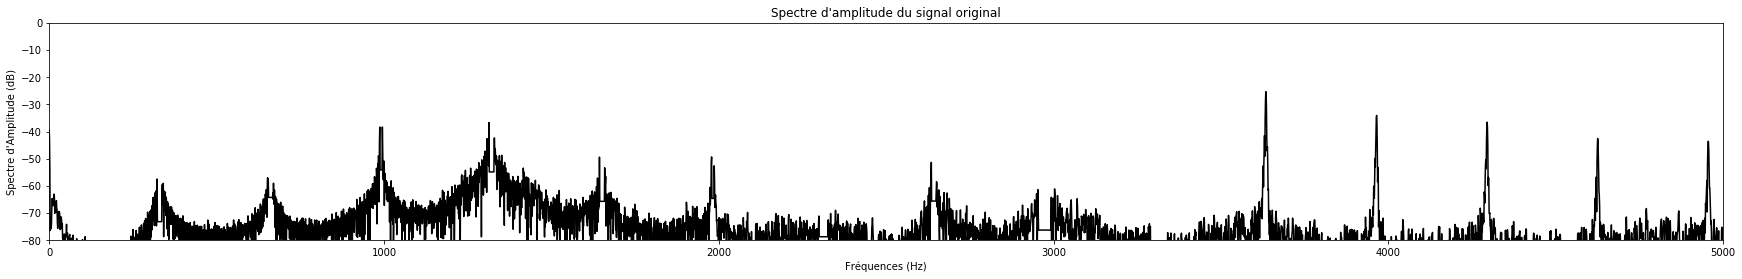

3589.84375
3671.875


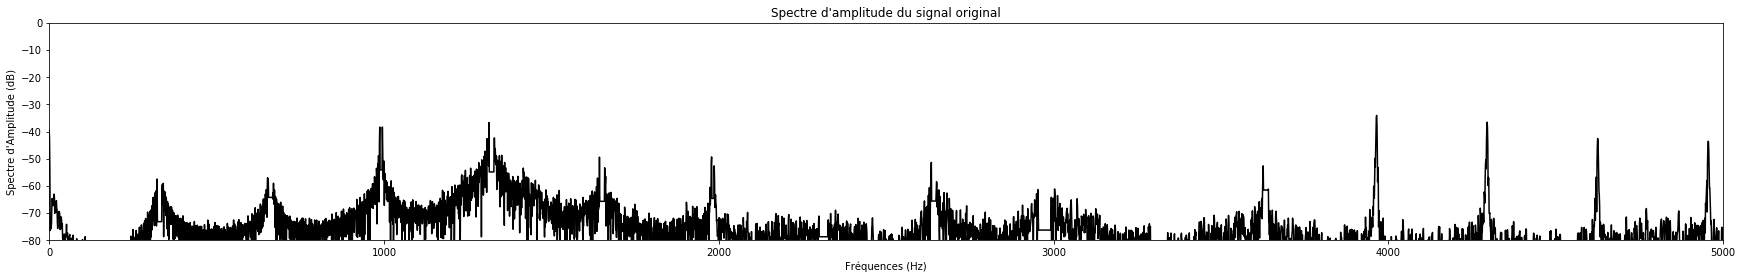

3919.921875
4001.953125


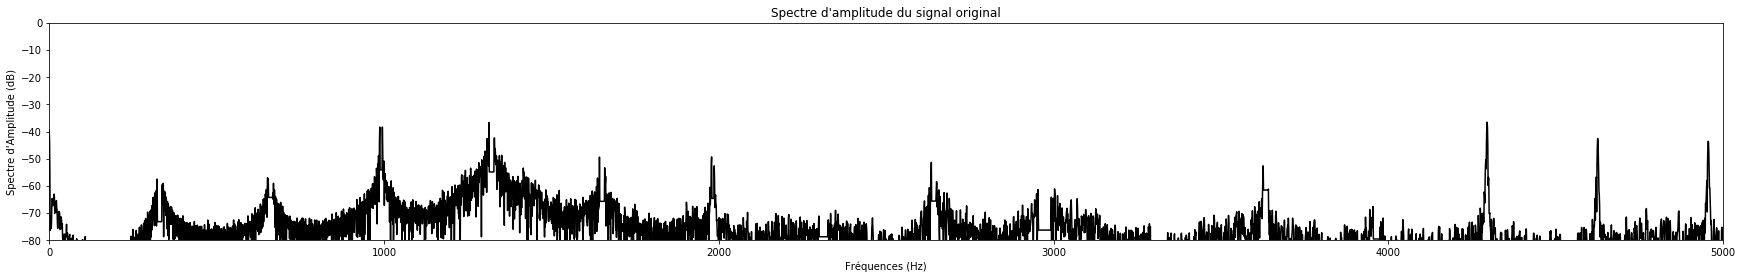

4250.0
4332.03125


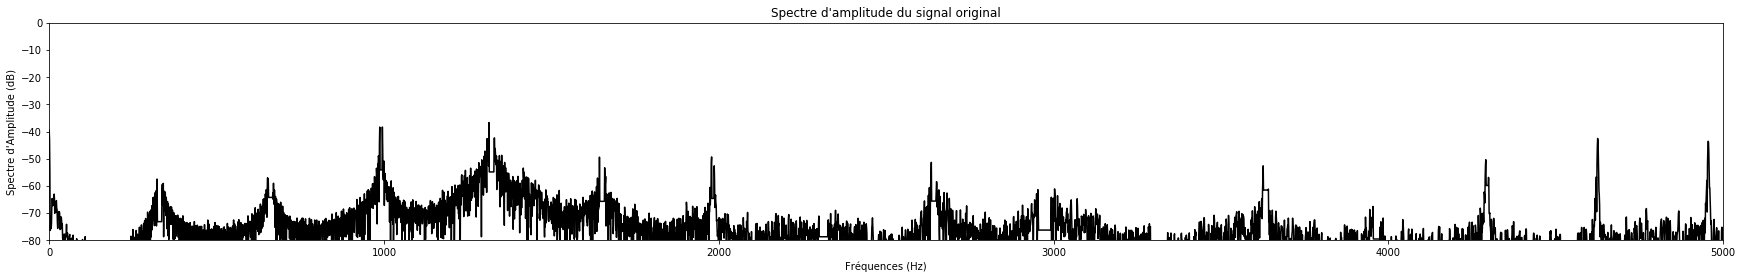

4580.078125
4662.109375


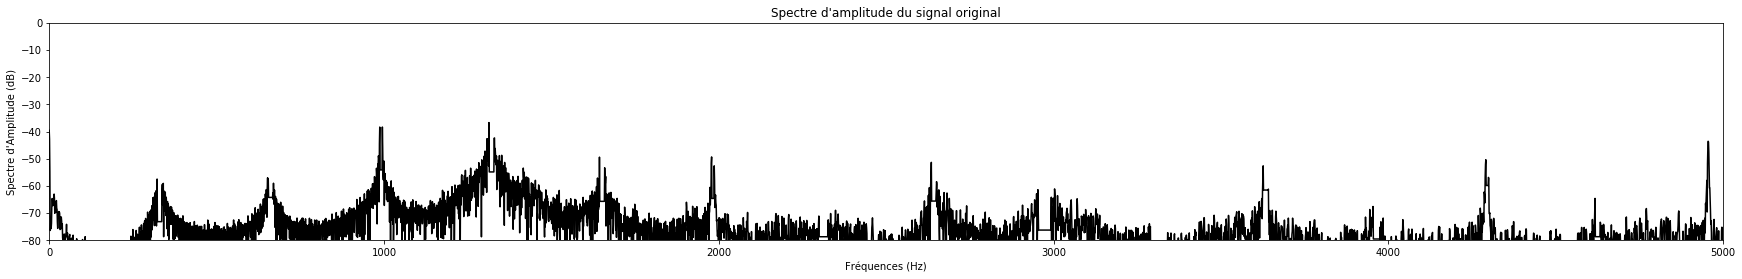

4910.15625
4992.1875


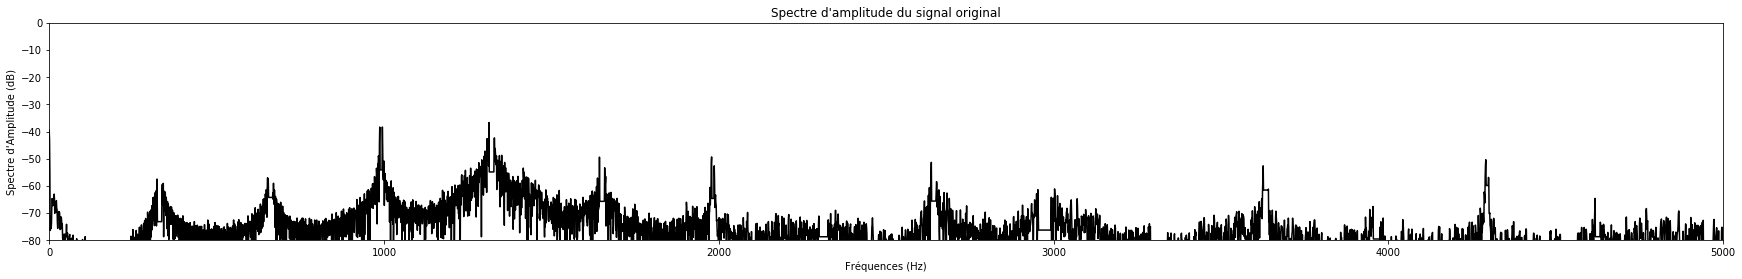

5240.234375
5322.265625


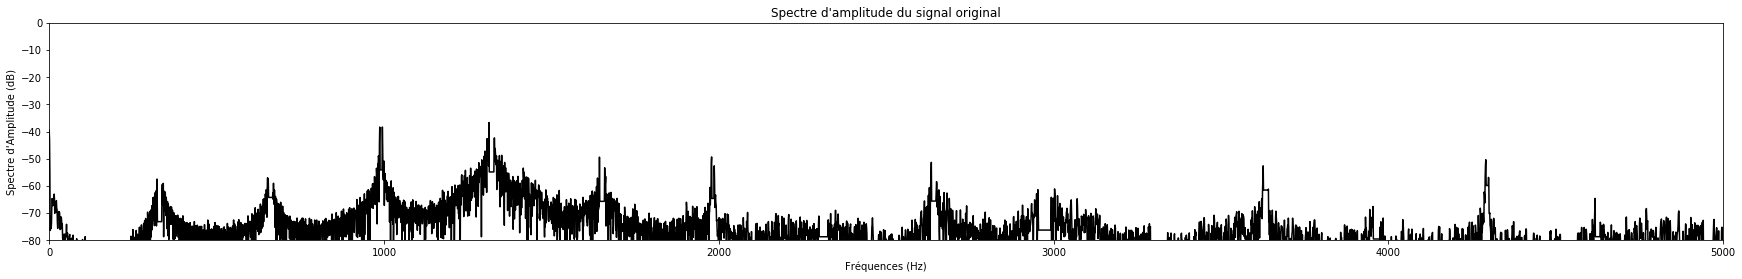

5570.3125
5652.34375


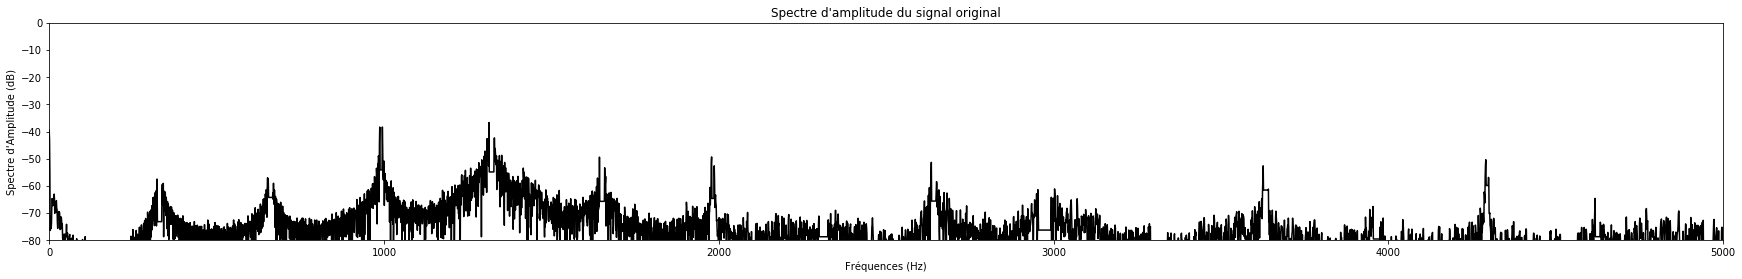

5900.390625
5982.421875


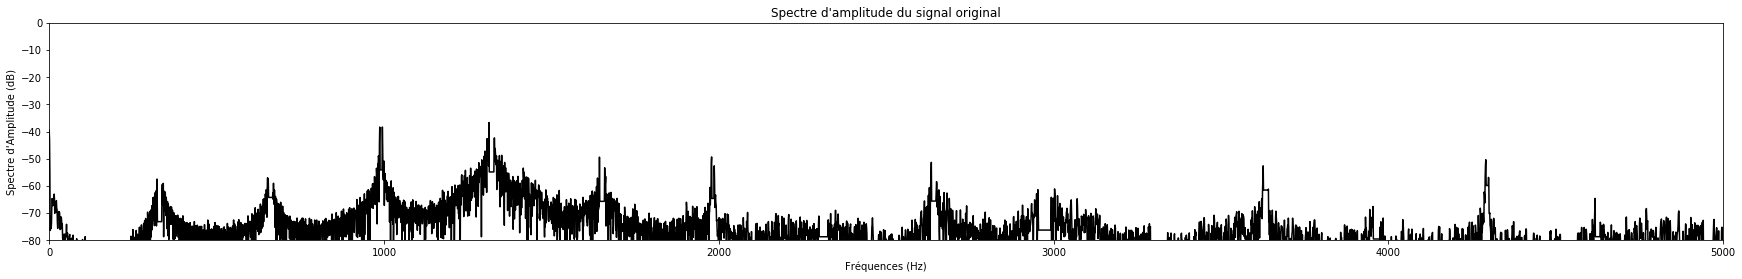

6230.46875
6312.5


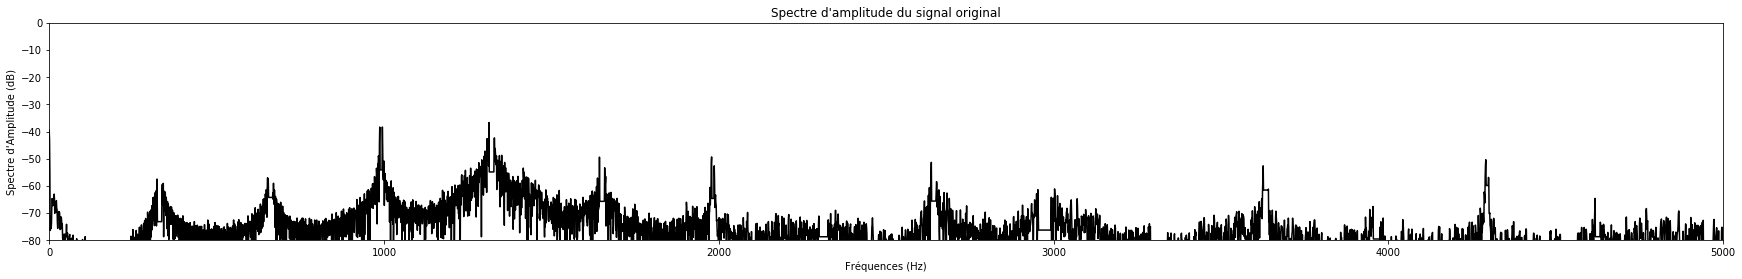

6560.546875
6642.578125


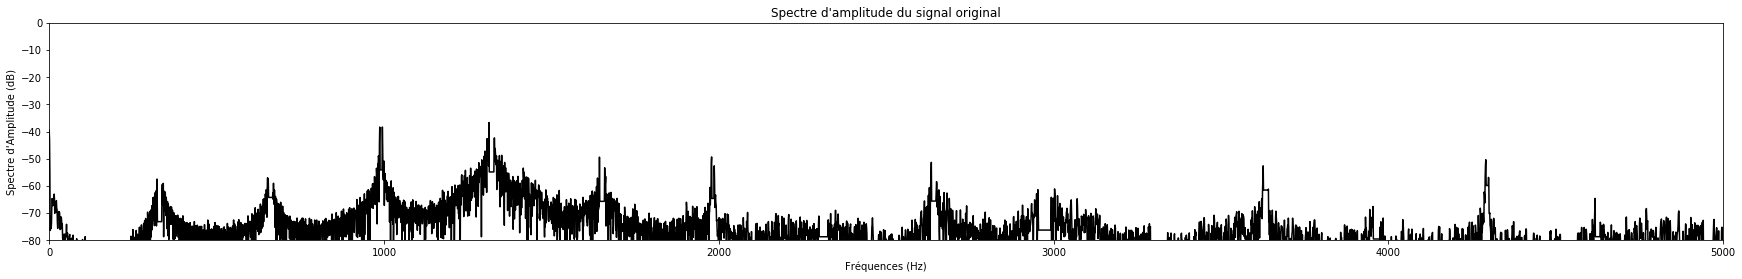

6890.625
6972.65625


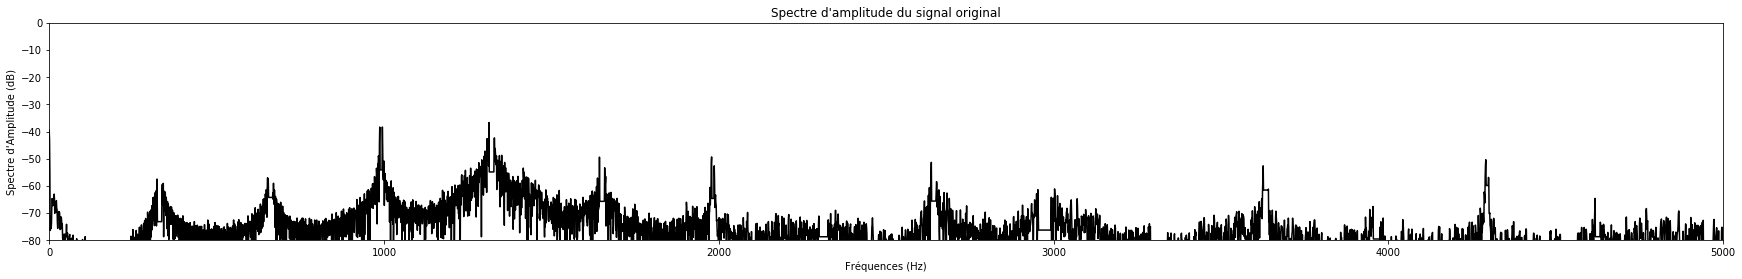

7220.703125
7302.734375


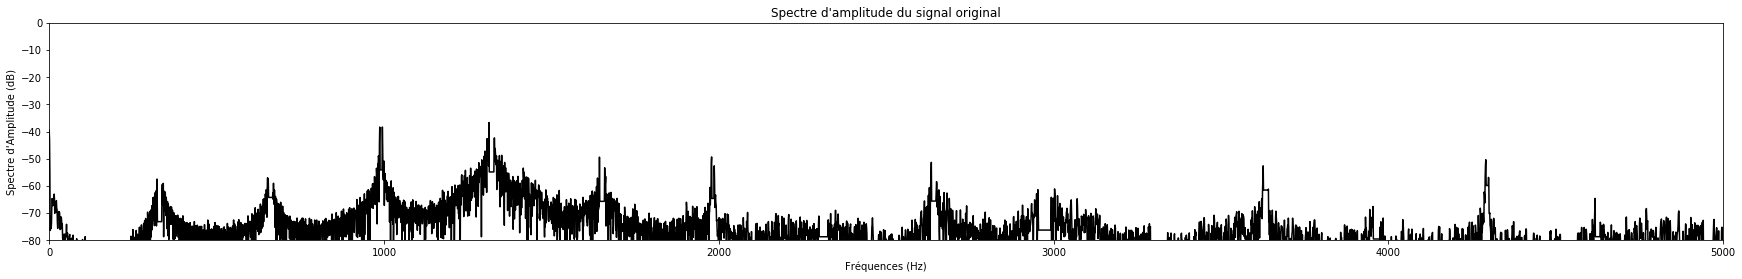

7550.78125
7632.8125


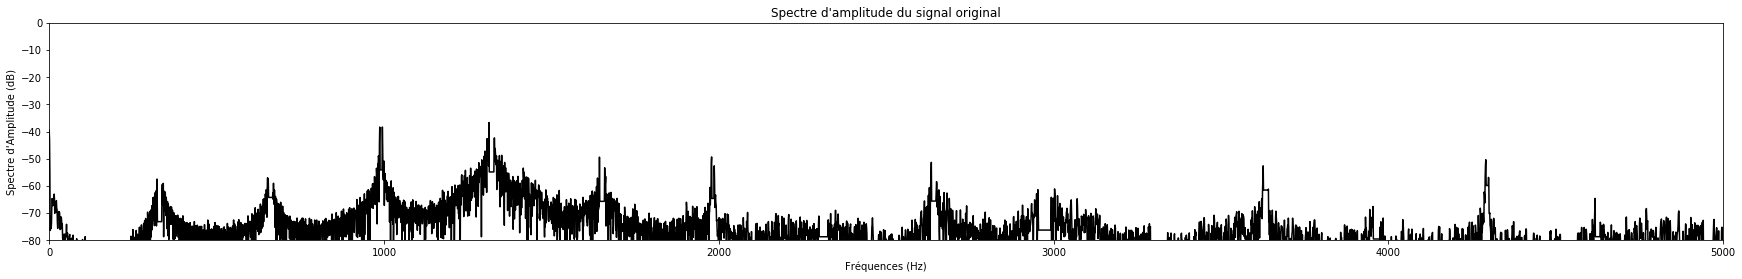

7880.859375
7962.890625


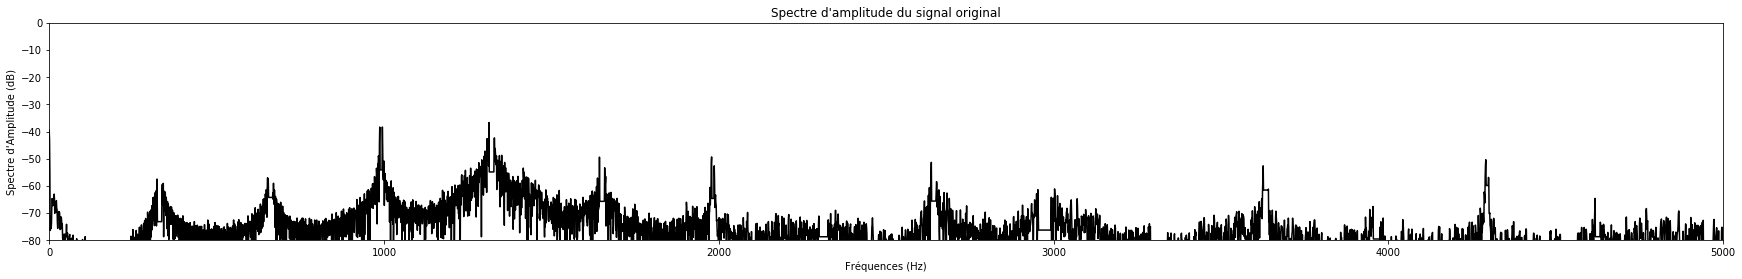

8210.9375
8292.96875


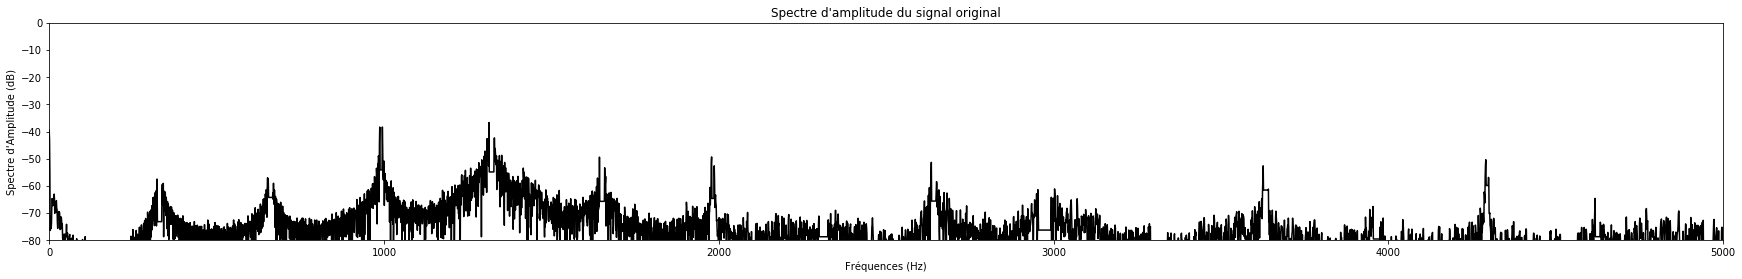

8541.015625
8623.046875


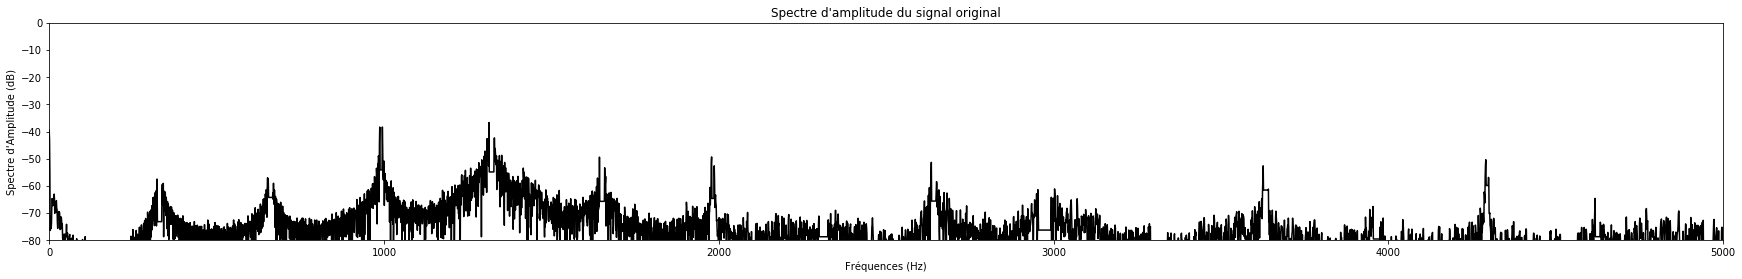

8871.09375
8953.125


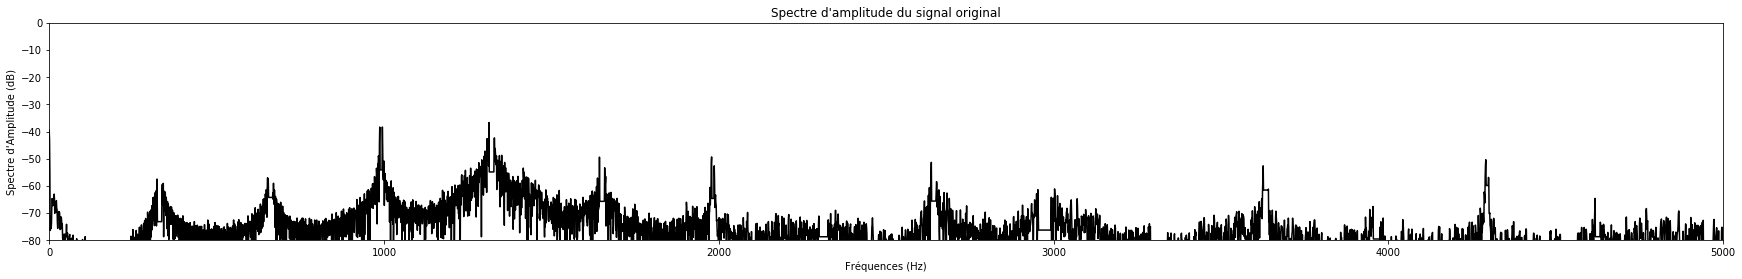

9201.171875
9283.203125


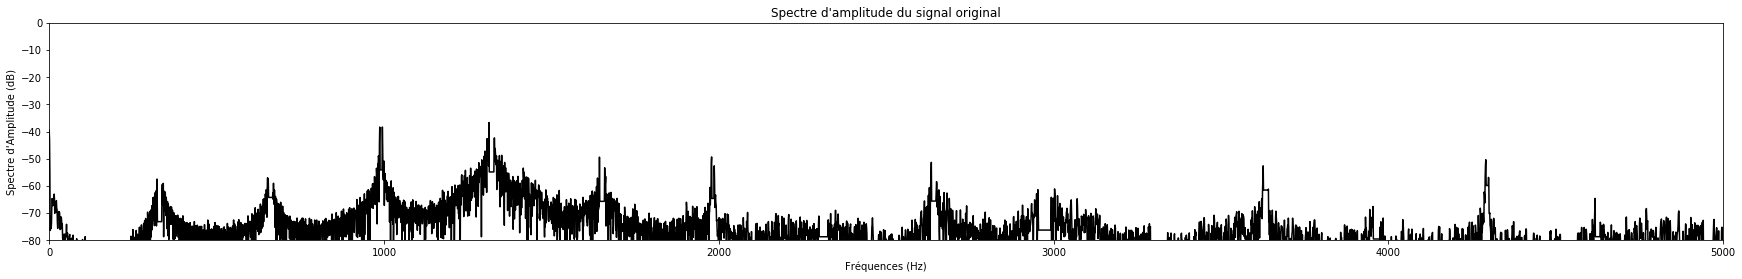

9531.25
9613.28125


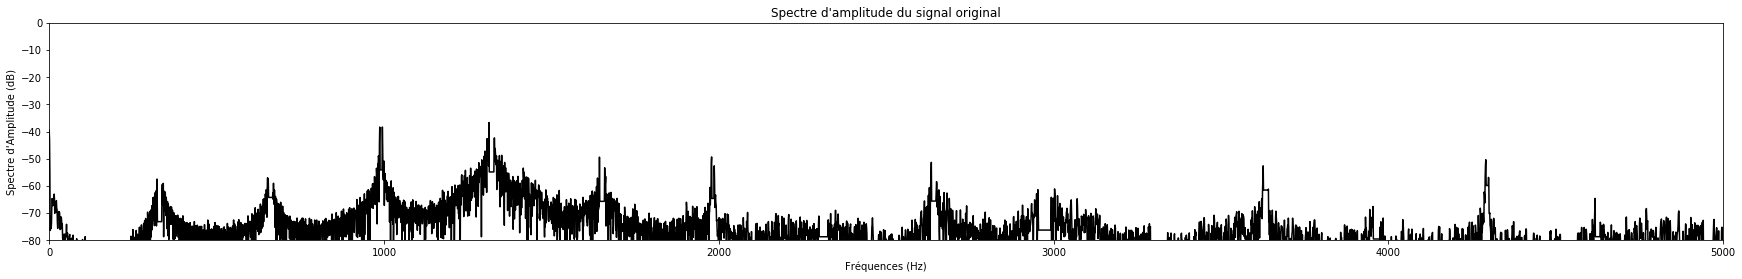

9861.328125
9943.359375


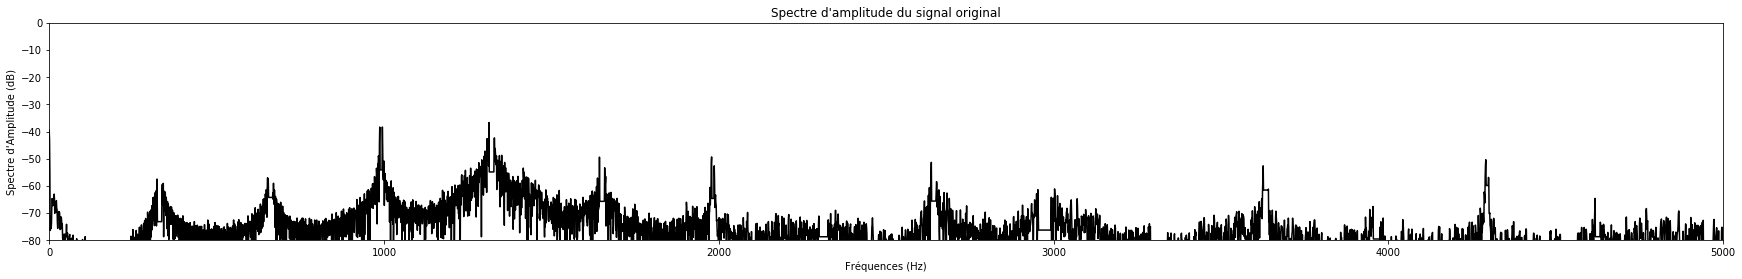

10191.40625
10273.4375


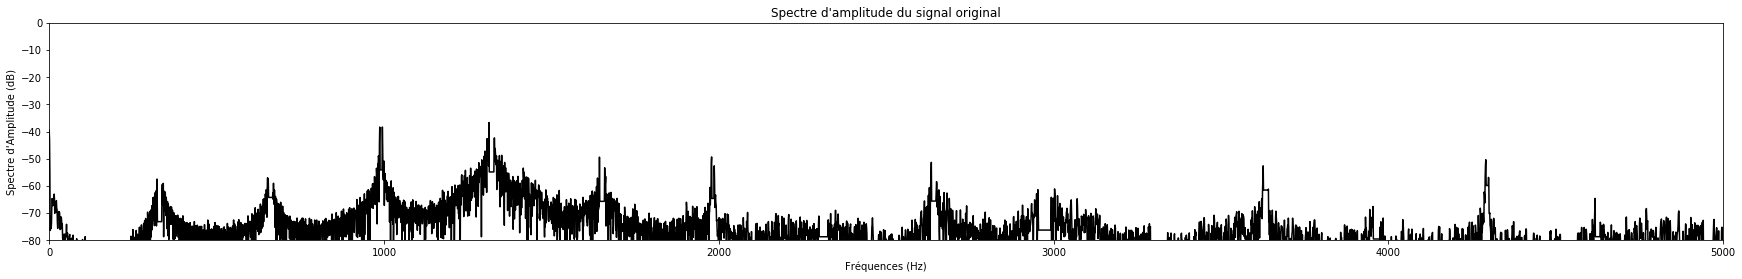

10521.484375
10603.515625


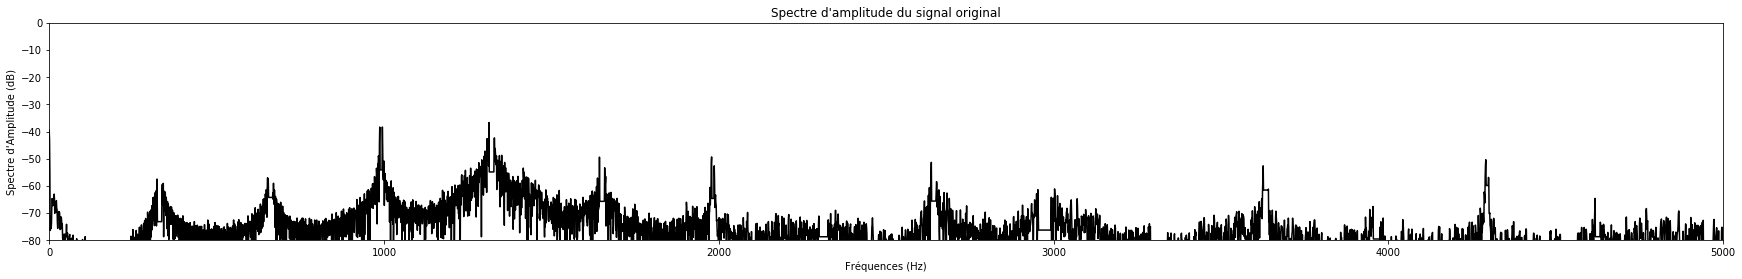

10851.5625
10933.59375


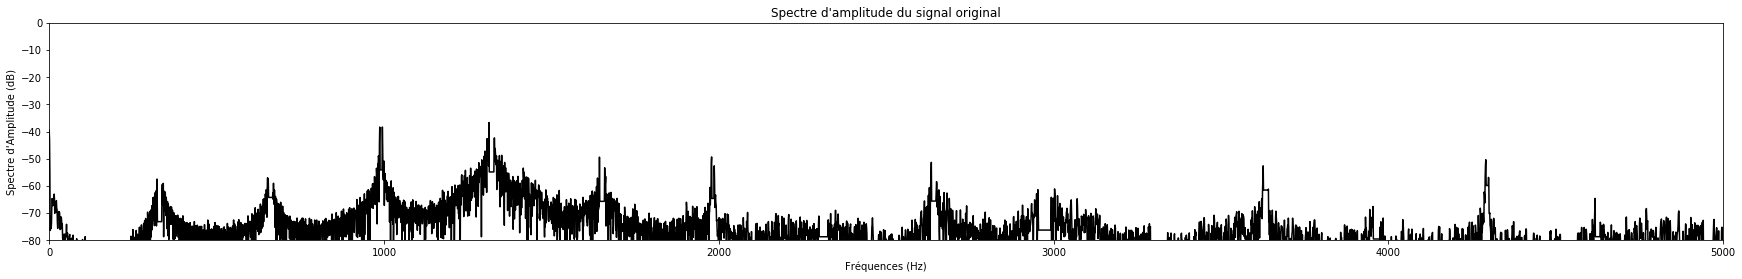

11181.640625
11263.671875


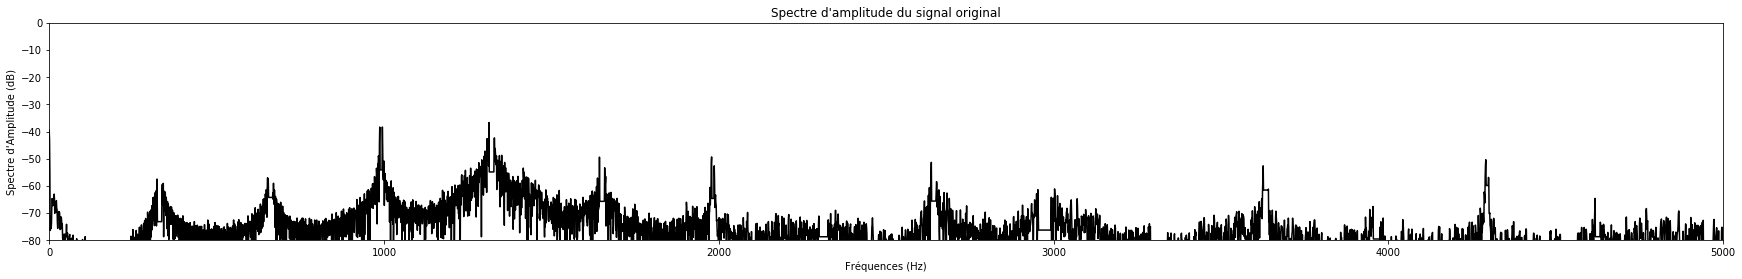

11511.71875
11593.75


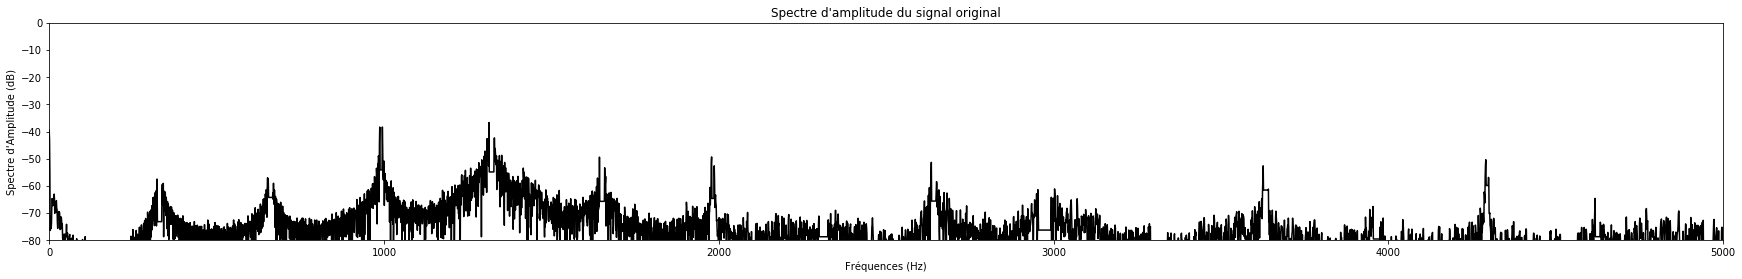

11841.796875
11923.828125


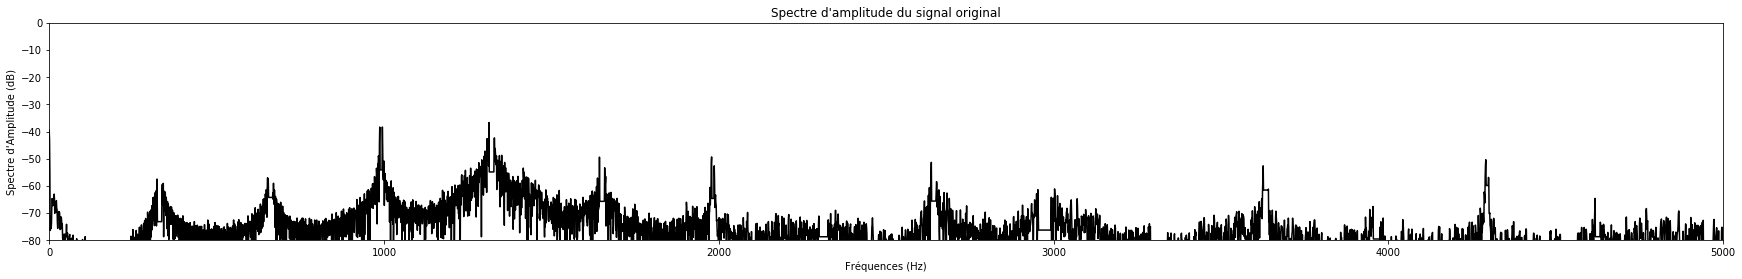

12171.875
12253.90625


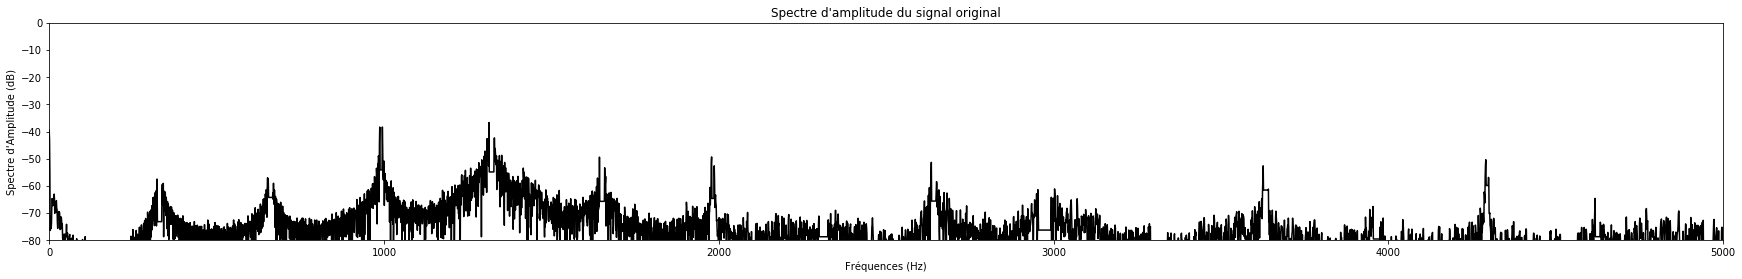

12501.953125
12583.984375


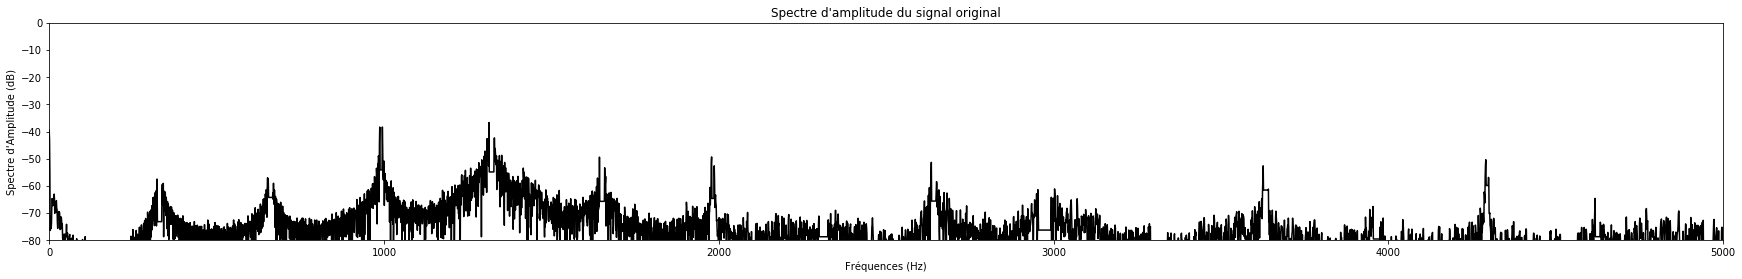

12832.03125
12914.0625


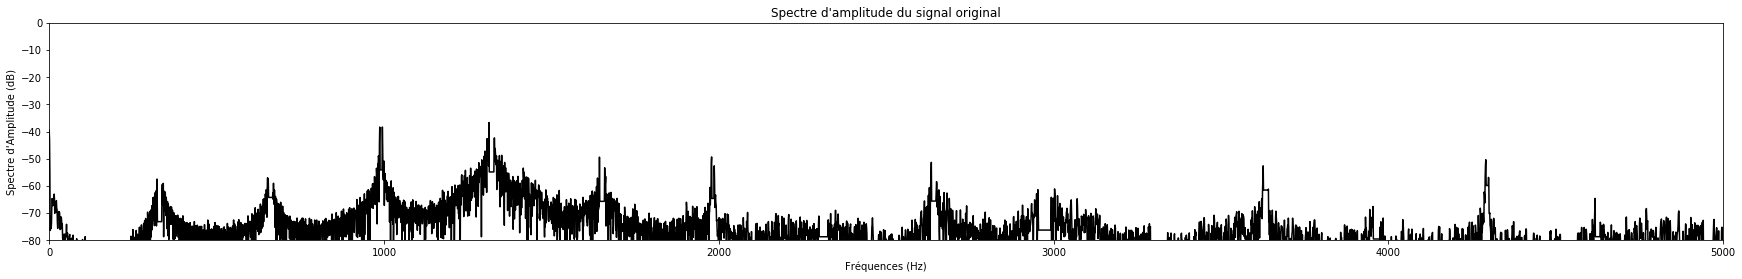

13162.109375
13244.140625


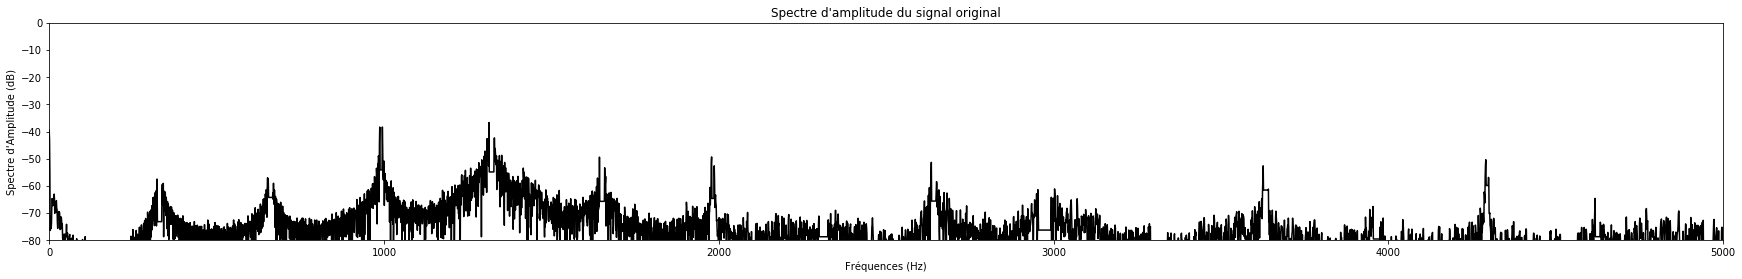

13492.1875
13574.21875


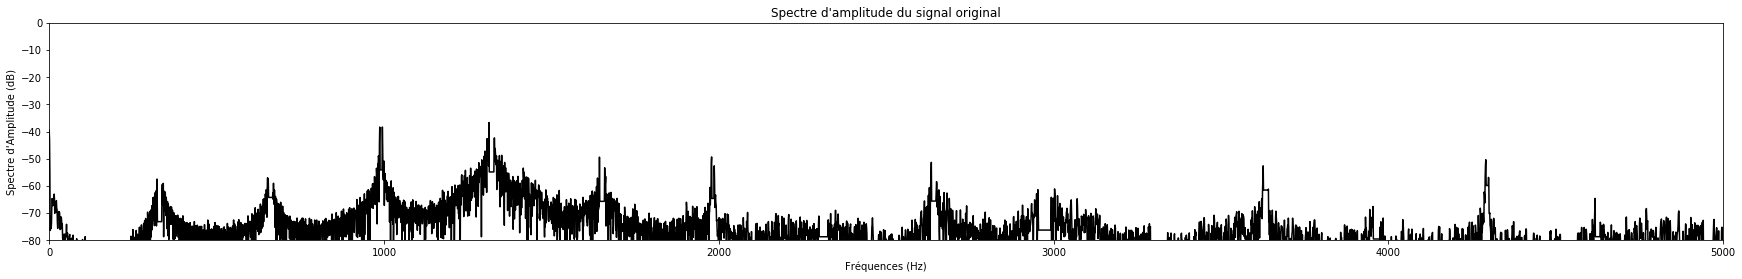

13822.265625
13904.296875


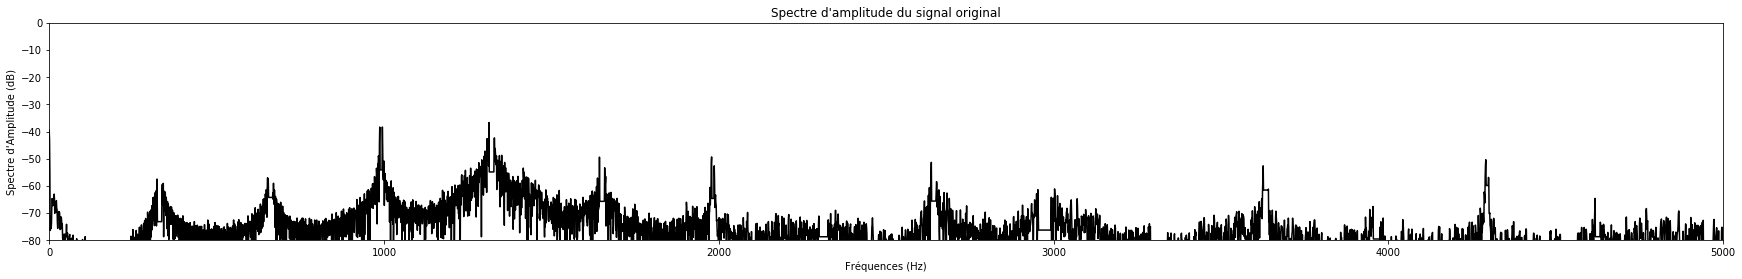

14152.34375
14234.375


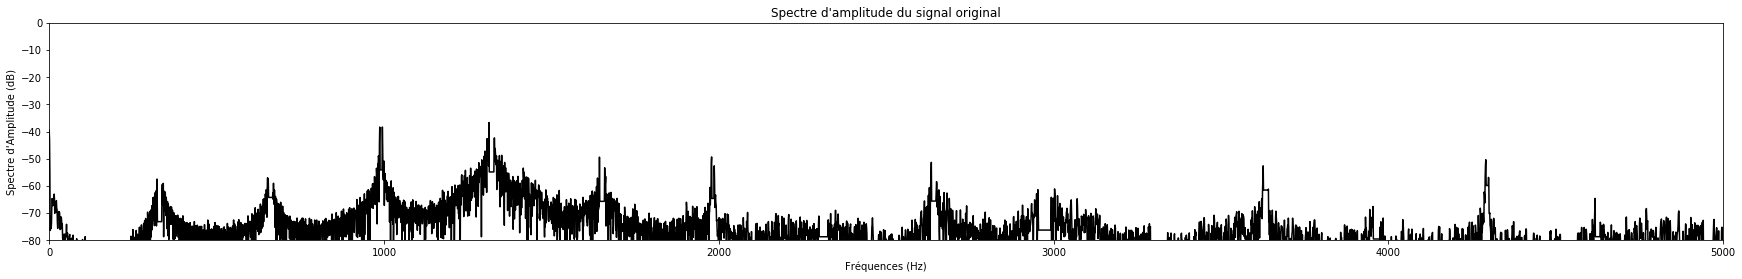

14482.421875
14564.453125


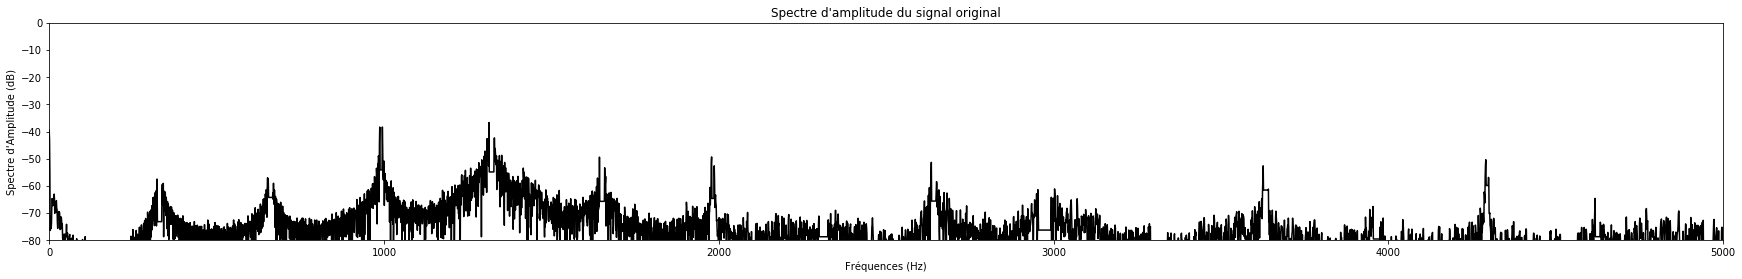

14812.5
14894.53125


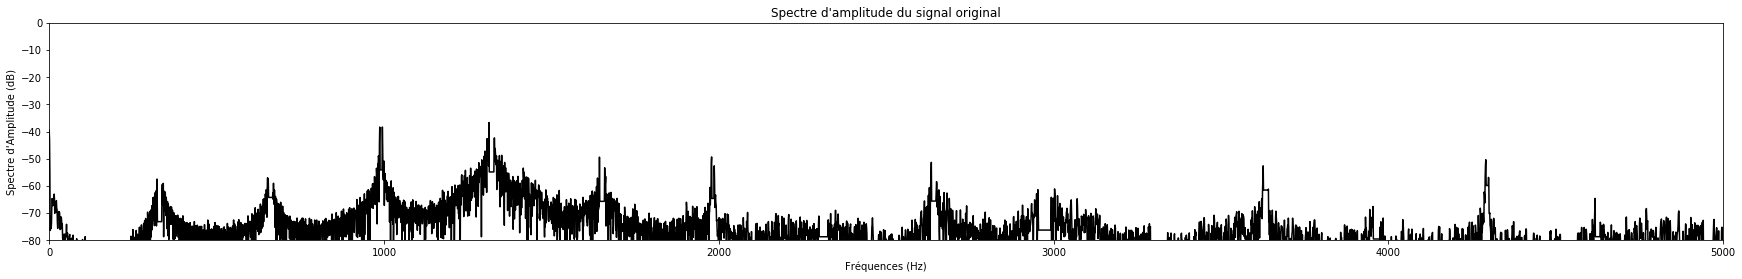

In [377]:
new_freq, new_fourier = delete_note(fr, fo, idx_f_0, f_0, inharmonicity=True)

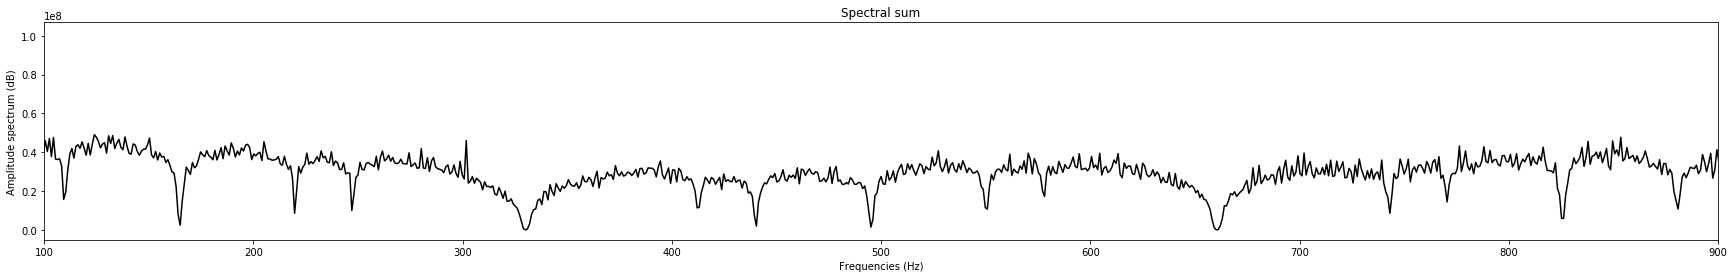

The fundamental frequency is 330.08 ± 1.43 Hz


In [119]:
def spectral_prod(fourier, H, R):
    '''Computation of the spectral product'''
    
    modules = np.zeros((H, R))
    for h in range(1,H+1):
        modules[h-1] = concentrate_spectrum(fourier, h, R)
    prod = np.prod(modules, axis=0)
    return prod


def get_fundamental_by_prod(freq, prod_s, H, R, Fmin, Fmax):
    '''Returns the fundamental frequency and the index of this fundamental frequency'''
    
    plt.figure(figsize=(30, 4))
    plt.plot(freq[:R], prod_s, color='k')
    plt.xlim(Fmin, Fmax)
    #plt.ylim(-80, 0)
    plt.xlabel('Frequencies (Hz)')
    plt.ylabel('Amplitude spectrum (dB)')
    plt.title('Spectral sum')
    plt.show()
    
    ind_min = len(freq[freq<Fmin])
    ind_max = len(freq[freq<Fmax])
    
    return freq[np.argmin(prod_s[ind_min:ind_max])+ind_min], np.argmin(prod_s[ind_min:ind_max])+ind_min

H = 4
R = 4000
prod_s = spectral_prod(fourier, H, R)
f_0, idx_f_0 = get_fundamental_by_prod(freq, prod_s, H, R, Fmin, Fmax)
print("The fundamental frequency is {:.5} ± {:.3} Hz".format(f_0, dF_min))

In [12]:
def spectral_prod(x, R, H):
    """
    Spectral Product
    """
    TO BE COMPLETED
    
    return prod


def spectral_sum(x, R, H):
    """
    Spectral sum
    """
    TO BE COMPLETED
    return summ


def spectral_method(x, R, H, method='product'):
    """
    Factorization of previous methods
    """
    assert method in ['sum', 'product']
    if method == 'sum':
        return spectral_sum(x, R, H)
    else:
        return spectral_prod(x, R, H)

SyntaxError: invalid syntax (<ipython-input-12-61815ac0684d>, line 5)

Maximum Search

In [13]:
method = 'product'
P = spectral_method(X_fft, Rmax, H, method)

NameError: name 'spectral_method' is not defined